# Análise de Risco de Crédito - NuBank

<div style="text-align: center;">
    <img src="../images/cartao-nubank.jpg" alt="Texto Alternativo" width="75%">
</div>

# Risco de Crédito e Prevenção de Inadimplência

O **risco de crédito** está associado à possibilidade de um cliente não cumprir com as obrigações contratuais, como hipotecas, dívidas de cartão de crédito e outros tipos de empréstimos. 

Minimizar o risco de inadimplência é uma grande preocupação para instituições financeiras. Por esse motivo, bancos comerciais e de investimento, fundos de capital de risco, empresas de gestão de ativos e seguradoras, entre outros, estão cada vez mais utilizando a tecnologia para prever quais clientes são mais propensos a não honrar suas dívidas.

## A Tecnologia no Gerenciamento de Risco

Modelos de **Machine Learning** têm ajudado essas empresas a melhorar a precisão de suas análises de risco de crédito, fornecendo um método científico para identificar devedores em potencial com antecedência.

## O Projeto: Previsão de Inadimplência para o Nubank

Neste projeto, construiremos um modelo para prever o risco de inadimplência de clientes para o **Nubank**, uma das maiores e mais importantes Fintechs brasileiras.

### Variável Dependente: Inadimplência

A inadimplência é a **variável dependente** neste caso, e seu evento pode ou não ocorrer, dependendo das variáveis explicativas inseridas nos modelos. Essas variáveis são **qualitativas dicotômicas**, representando cada um dos fenômenos em estudo. O objetivo é estimar a probabilidade de ocorrência desse fenômeno.

### Técnica Inicial Utilizada: Regressão Logística Binária

Para isso, faremos uso da **regressão logística binária**. O caso apresenta a inadimplência por meio de duas categorias:

- **`target_default` com valor `False`**: Representa o não evento de interesse (dummy = 0).
- **`target_default` com valor `True`**: Representa o evento de interesse (dummy = 1).

A primeira categoria será a de referência, e a segunda indicará o evento de inadimplência. A regressão logística binária será utilizada para estimar a probabilidade de ocorrência do evento de interesse.

# Modelagem 

## Objetivo

- **Prever o risco de inadimplência de clientes** utilizando modelos de aprendizado de máquina, incluindo:
  - Regressão Logística
  - Random Forest
  - XGBoost
  - LightGBM
  - CatBoost

- **Problema**: Identificar a possibilidade de clientes não cumprirem obrigações contratuais, como empréstimos e pagamentos.

# Importação das Bibliotecas

In [8]:
# Importações de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, recall_score
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay


# Outras bibliotecas
import sys
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap
from scipy.stats.mstats import winsorize
from scipy.stats import randint, uniform
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Verifique se a biblioteca 'statstests' está instalada antes de importar
try:
    from statstests.process import stepwise
except ModuleNotFoundError:
    print("Aviso: O módulo 'statstests' não foi encontrado. Verifique se ele está instalado.")

# Configurações de warnings
import warnings
warnings.filterwarnings('ignore')

# Configurações do pandas
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', None)  # Mostra todas as linhas
pd.set_option('display.max_columns', None)  # Mostra todas as colunas

# Verifique se o módulo 'exception' está disponível antes de importar
try:
    from exception import CustomException
except ModuleNotFoundError:
    print("Aviso: O módulo 'exception' não foi encontrado. Certifique-se de que ele está disponível.")

# Funções

In [9]:
###################### Funcão para detectar Outliers e Substituir por NaN ######################
# Função que detecta e substitui outliers por NaN com base no método IQR.
def detectar_e_substituir_outliers(df):

    for column in df.select_dtypes(include=[np.number]).columns:  # Process only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with NaN
        df[column] = df[column].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

    print("Os valores discrepantes foram substituídos por NaN.")
    return df

###################### Função da Matriz de Confusão ######################
def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores


###################### Função da Curva ROC ######################
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Cálculo do coeficiente de GINI
    gini = (roc_auc - 0.5) / 0.5

    # Plotando a curva ROC
    plt.figure(figsize=(15, 10))
    plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3, label='Curva ROC')
    plt.plot(fpr, fpr, color='gray', linestyle='dashed', label='Linha de Referência')
    plt.title(f'Área abaixo da curva: {round(roc_auc, 4)} | Coeficiente de GINI: {round(gini, 4)}', fontsize=22)
    plt.xlabel('1 - Especificidade', fontsize=20)
    plt.ylabel('Sensitividade', fontsize=20)
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
    plt.legend(loc='lower right', fontsize=14)
    plt.grid(True)
    plt.show()

###################### Função 'espec_sens' ######################
# Criação da função 'espec_sens' para a construção de um 
# dataset com diferentes valores de cutoff, sensitividade e especificidade

def espec_sens(observado,predicts):
    
    values = predicts.values
    
    cutoffs = np.arange(0,1.01,0.01)
    
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado


###################### Função para mudar Boolean para Inteiro ######################
def convert_boolean_to_int(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].fillna(False).astype(int)
    else:
        raise ValueError(f"A coluna '{column_name}' não existe no Dataframe.")
    return df

###################### Função para substituir Features com valores 0 para Nan ######################
def replace_zero_with_nan(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: np.nan if x == 0 else x)
    return df

###################### Função para mudar valores Inf e -Inf para Nan ######################
def replace_inf_with_nan(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

###################### Função para categorizar o score_3 ######################
def categorize_score(df, column="score_3"):
    df["score"] = ""
    df.loc[df[column] <= 300, "score"] = "baixo"
    df.loc[(df[column] >= 301) & (df[column] <= 700), "score"] = "medio"
    df.loc[df[column] >= 701, "score"] = "alto"
    
    return df

###################### Função para aplicar o OneHotEncoding ######################
def apply_one_hot_encoding(df, column):

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data = encoder.fit_transform(df[[column]])
    
    encoded_columns = encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)
    
    df = pd.concat([df.drop(columns=[column]), encoded_df], axis=1)
    return df


# Importação do Dataset

In [10]:
df = pd.read_csv('data/acquisition_train.csv')

# Visualização dos Dados

In [11]:
df.head(2).T

,0,1
ids,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,bc2c7502-bbad-0f8c-39c3-94e881967124
target_default,False,False
score_1,1Rk8w4Ucd5yR3KcqZzLdow==,DGCQep2AE5QRkNCshIAlFQ==
score_2,IOVu8au3ISbo6+zmfnYwMg==,SaamrHMo23l/3TwXOWgVzw==
score_3,350.00,370.00
score_4,101.80,97.06
score_5,0.26,0.94
score_6,108.43,92.00
risk_rate,0.40,0.24
last_amount_borrowed,"25,033.92",NaN


# Infos dos Dados

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

- Temos dados ausentes

# Exclusão das Variáveis não significativas

- Seguindo como base os processos feitos na Análise Exploratória de Dados - EDA, vamos excluir logo de início as variáveis não relevantes para o projeto, seguido da variável **Shipping State** por não agregar até o momento nenhuma significância para o projeto. Por enquanto não temos valor na distribuição dos estados com relação as outras variáveis.

**Cópia do Dataframe**

In [13]:
# cópia do dataframe
df2 = df.copy()

**Exclusão das Colunas não significativas**

In [14]:
exclude_columns = ["ids", "score_1", "score_2", "score_4", "score_5", "score_6","reason", "facebook_profile", "state", "zip", "channel", "job_name", "real_state",
                    "email", "external_data_provider_first_name", "external_data_provider_email_seen_before","lat_lon", "marketing_channel",
                    "application_time_applied", "profile_phone_number", "application_time_in_funnel","shipping_zip_code", "external_data_provider_fraud_score",
                    "profile_tags", "user_agent", "shipping_state","target_fraud"]

df2.drop(labels = exclude_columns, axis=1, inplace=True)

# Alteração da variável Target Default para Num

- Neste código convertemos os valores **booleanos (True ou False)** da coluna target_default para valores numéricos (1 ou 0, respectivamente). Isso é comum em machine learning ou análise de dados, onde variáveis categóricas ou booleanas precisam ser transformadas em números para serem processadas por algoritmos.

In [15]:
df2 = convert_boolean_to_int(df2, "target_default")

# Alteração da Variável credit_limit com valor 0

- A variável **credit_limit** possui um valor mínimo de 0.000000, isso não existe em instituições financeiras, é obrigatório liberar um valor X de crédito para o cliente. Portanto, este valor será substituído por NaN.

In [16]:
df2 = replace_zero_with_nan(df2, "credit_limit")

# Alteração da Variável reported_income com Valor Inf

- A variável **reported_income** possui um valor máximo descrito como inf(infinito), nesse caso, vamos alterar para o tipo NaN.

In [17]:
df2 = replace_inf_with_nan(df2)

# Feature Engineering

## Criação da Variável `Scores`

Seguindo o que foi feito com as **"Perguntas de Negócio utilizando o Score 3"** na **Análise Exploratória** do arquivo `eda.ipynb`, que é o score mais robusto para o projeto, vamos criar uma nova variável chamada **`Scores`**. Essa variável será dividida com base na descrição do score anteriormente mencionada.

### Divisão do Score Brasileiro

O score brasileiro é geralmente dividido em faixas:

- **Baixo (0-300):** Alto risco de inadimplência.
- **Médio (301-700):** Risco moderado.
- **Alto (701-1000):** Baixo risco de inadimplência.

### Implementação

Com base nessa divisão, criaremos uma variável chamada **`score`**, que será categorizada de acordo com as faixas acima. Além disso, para essa nova análise, **excluiremos as outras colunas de score** existentes.

In [18]:
df2 = categorize_score(df2)

- Exclusão da variável score_3

In [19]:
df2.drop(columns=['score_3'], axis = 1, inplace = True)	

# Modelos Logísticos Binários

## Respostas Binárias e Regressão Logística

Respostas binárias são comumente estudadas em diversos campos. Exemplos incluem:

- Presença ou ausência de uma doença específica.
- Morte durante uma cirurgia.
- Decisão de um consumidor em comprar um produto.

Frequentemente, o objetivo é estudar como um conjunto de **variáveis preditoras** (**X**) está relacionado a uma **variável de resposta dicotômica** (**Y**). Esses preditores podem incluir:

- Atribuição de tratamento.
- Dosagem.
- Fatores de risco.
- Tempo de calendário.

## Definição da Resposta Binária

Por conveniência, definimos a resposta como **Y = 0** ou **Y = 1**, onde:

- **Y = 1** denota a ocorrência do evento de interesse.
- **Y = 0** denota a não ocorrência.

Em muitos casos, um resultado dicotômico pode ser estudado calculando proporções, como:

- Proporção de mortes entre mulheres.
- Proporção de mortes entre homens.

No entanto, quando há múltiplos descritores ou quando um ou mais descritores são contínuos, a análise se torna mais complexa. Sem um modelo estatístico, seria necessário criar grupos arbitrários (por exemplo, faixas etárias) para estimar a prevalência de uma doença em função da idade.

## Regressão Logística vs. Regressão Linear

Diferentemente da **regressão linear tradicional**, que é estimada por métodos de **mínimos quadrados** e aplicada a variáveis dependentes quantitativas, a **regressão logística** é utilizada quando a variável dependente é qualitativa. Nesses casos, a variável dependente é representada por uma ou mais variáveis **dummy**, dependendo do número de categorias possíveis.

## Características da Regressão Logística

- **Variável dependente**: Binária (0 ou 1).
- **Variáveis preditoras**: Podem ser métricas (contínuas) ou não métricas (categóricas).
- **Interpretação**: Os resultados são expressos em termos de probabilidades.

## Aplicação em Machine Learning

Em **Machine Learning**, a regressão logística é uma técnica **supervisionada** usada para:

1. **Explicar** a probabilidade de ocorrência de um evento.
2. **Prever** a ocorrência de um evento com base em uma ou mais variáveis explicativas.

Essa técnica é especialmente útil quando a variável dependente é binária, e os resultados são interpretados como probabilidades.

## O Modelo de Regressão Logística Binária

O modelo de regressão logística binária é uma técnica estatística usada para prever a probabilidade de ocorrência de um evento que tem dois resultados possíveis (binário). Ele é amplamente utilizado em problemas de classificação, onde a variável dependente (resposta) é categórica e assume apenas dois valores, como 0 ou 1, "Sim" ou "Não", "Sucesso" ou "Fracasso".

## Conceito Básico

A regressão logística modela a probabilidade de um evento ocorrer usando uma função logística (também chamada de sigmoide). A função **sigmoide** transforma qualquer valor real em um valor entre 0 e 1, que pode ser interpretado como uma probabilidade.

## Função Sigmoide

A função sigmoide é dada por:

$$P(Y = 1 \mid X) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n\right)}}$$

Onde: 

- $P(Y = 1 \mid X)$ é a probabilidade de a variável dependente **Y** ser igual a 1, dado o conjunto de variáveis independentes **X**.

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são os coeficientes do modelo.

- $X_1, X_2, \dots, X_n$ são as variáveis independentes (ou características).

- $e$ é a base do logaritmo natural (aproximadamente 2.71828).





## Função de Ligação (Logit)

A regressão logística usa a função de ligação logit para modelar a relação entre as variáveis independentes e a probabilidade de ocorrência do evento. O logit é o logaritmo natural da razão de chances (odds ratio):

$$\text{logit}(P(Y = 1 \mid X)) = \ln\left(\frac{1 - P(Y = 1 \mid X)}{P(Y = 1 \mid X)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$


## Estimação dos Coeficientes

Os coeficientes $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são estimados usando o método de máxima verossimilhança (Maximum Likelihood Estimation - MLE). O objetivo é encontrar os valores dos coeficientes que maximizam a função de verossimilhança, que é a probabilidade de observar os dados dados os parâmetros do modelo.

## Interpretação dos Coeficientes

- Coeficiente $\beta_0$: É o intercepto do modelo. Representa o logaritmo da razão de chances quando todas as variáveis independentes são iguais a zero.

- Coeficientes $\beta_1, \beta_2, \dots, \beta_n$: Representam a mudança no logaritmo da razão de chances para um aumento unitário na variável independente correspondente, mantendo todas as outras variáveis constantes.

## Odds

Na regressão logística, o conceito de chance (ou odds, em inglês) é fundamental para entender como o modelo estima a probabilidade de um evento ocorrer. Vamos explorar o que significa "chance" e como ela se relaciona com a regressão logística.

1. O que é Chance?

A chance é uma medida que compara a probabilidade de um evento ocorrer com a probabilidade de ele não ocorrer. Em outras palavras, é a razão entre a probabilidade de sucesso $\left(P(Y = 1)\right)$ e a probabilidade de fracasso $\left(P(Y = 0)\right)$
.

A fórmula da chance é: 

$$\text{Chance} = \frac{P(Y = 1)}{1 - P(Y = 1)}$$

Onde: 

- ${P(Y = 1)}$ é a probabilidade de o evento ocorrer.
- ${1 - P(Y = 1)}$ é a probabilidade de o evento não ocorrer.



2. Exemplo de Chance

Suponha que a probabilidade de um evento ocorrer seja $(P(Y = 1) = 0.75$. Então:

- A probabilidade de o evento não ocorrer é $1 - 0,75 = 0,25$.
- A chance de o evento ocorrer é: $$\text{Chance} = \frac{0,75}{0,25} = 3$$

Isso significa que a chance de o evento ocorrer é **3 para 1** (ou seja, o evento é 3 vezes mais provável de ocorrer do que não ocorrer).

3. Chance e Regressão Logística

Na regressão logística, o modelo estima a chance de um evento ocorrer com base nas variáveis independentes $(X)$. A relação entre as variáveis independentes e a chance é modelada pela função logística.

A regressão logística usa o **logaritmo da chance** (também chamado de logit) como variável dependente. A fórmula do logit é:

$$\text{logit}(P(Y = 1)) = \ln\left(\frac{P(Y = 1)}{1 - P(Y = 1)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$

Onde:

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são os coeficientes do modelo.
- $X_1, X_2, \dots, X_n$ são as variáveis independentes (ou características).


# Divisão dos dados em treino e teste

- Antes de iniciar as transformações e pré-processamentos dos dados, é necessário dividir o dataset em treino e teste, mas porque?
    - Porque precisamos evitar o "Data Leakage". Data Leakage ocorre quando informações do conjunto de dados de teste ou validação vazam para o conjunto de treinamento durante o pré-processamento ou modelagem, ou quando informaçõpes do target vazam para as features. Nessas situações, o que vai acontecer é que você vai ver um modelo muito bom, mas isso será ilusório, pois o seu modelo "roubou" para ter o resultado bom.

- Referências sobre Data Leakage: 
    - https://www.linkedin.com/company/universidade-dos-dados/posts/?feedView=all
    - https://www.casadocodigo.com.br/products/livro-escd
    - https://estatsite.com.br/2020/12/12/data-leakage-o-erro-que-ate-os-grandes-cometem/


In [20]:
# Dividindo os dados primeiro

X = df2.drop(columns=['target_default'], axis = 1)	
y = df2['target_default'].copy()                                                                                                                                                                                                                                                                                    

# Aplicando o One Hot Encoding antes do Train Test Split

In [21]:
X = apply_one_hot_encoding(X, "score")

# Modificação nos Outliers

- Aqui vamos modificar os Outliers para um primeiro CRISP-DM, vamos utilizar uma técnica chamada Winsorization (Winsorização).

## Winsorization (Winsorização)

Winsorization (ou winsorização, em português) é uma técnica estatística utilizada para reduzir o impacto de valores extremos (outliers) em um conjunto de dados. Em vez de simplesmente remover os outliers, a winsorização os substitui por valores mais próximos dentro de um limite especificado.

## Como funciona?
O processo básico da winsorização envolve:
1. Escolher um percentil inferior e superior para definir os limites.
2. Substituir os valores abaixo do percentil inferior pelo próprio valor do percentil inferior.
3. Substituir os valores acima do percentil superior pelo próprio valor do percentil superior.

Por exemplo, ao aplicar uma winsorização de 5%, os menores 5% dos dados são substituídos pelo valor do percentil 5%, e os maiores 5% são substituídos pelo valor do percentil 95%.

## Quando usar?
A winsorização é útil quando:
- Queremos minimizar o impacto de valores extremos sem removê-los completamente.
- Trabalhamos com dados sensíveis a outliers, como médias e regressões.
- Precisamos preservar a estrutura geral dos dados enquanto evitamos distorções causadas por valores discrepantes.

## Conclusão
A winsorização é uma técnica eficaz para tratar outliers sem descartá-los completamente. No entanto, a escolha do nível de winsorização deve ser feita com cuidado para evitar perda excessiva de informações valiosas nos dados.


## Winsorization

In [22]:
# Definir os percentis de Winsorization (5% em cada extremidade)
limites = (0.05, 0.05)
X_winsorized = X.apply(lambda x: winsorize(x, limits=limites) if x.dtype in [np.float64, np.int64] else x)


## Boxplot Dataframe Pós Winsorization

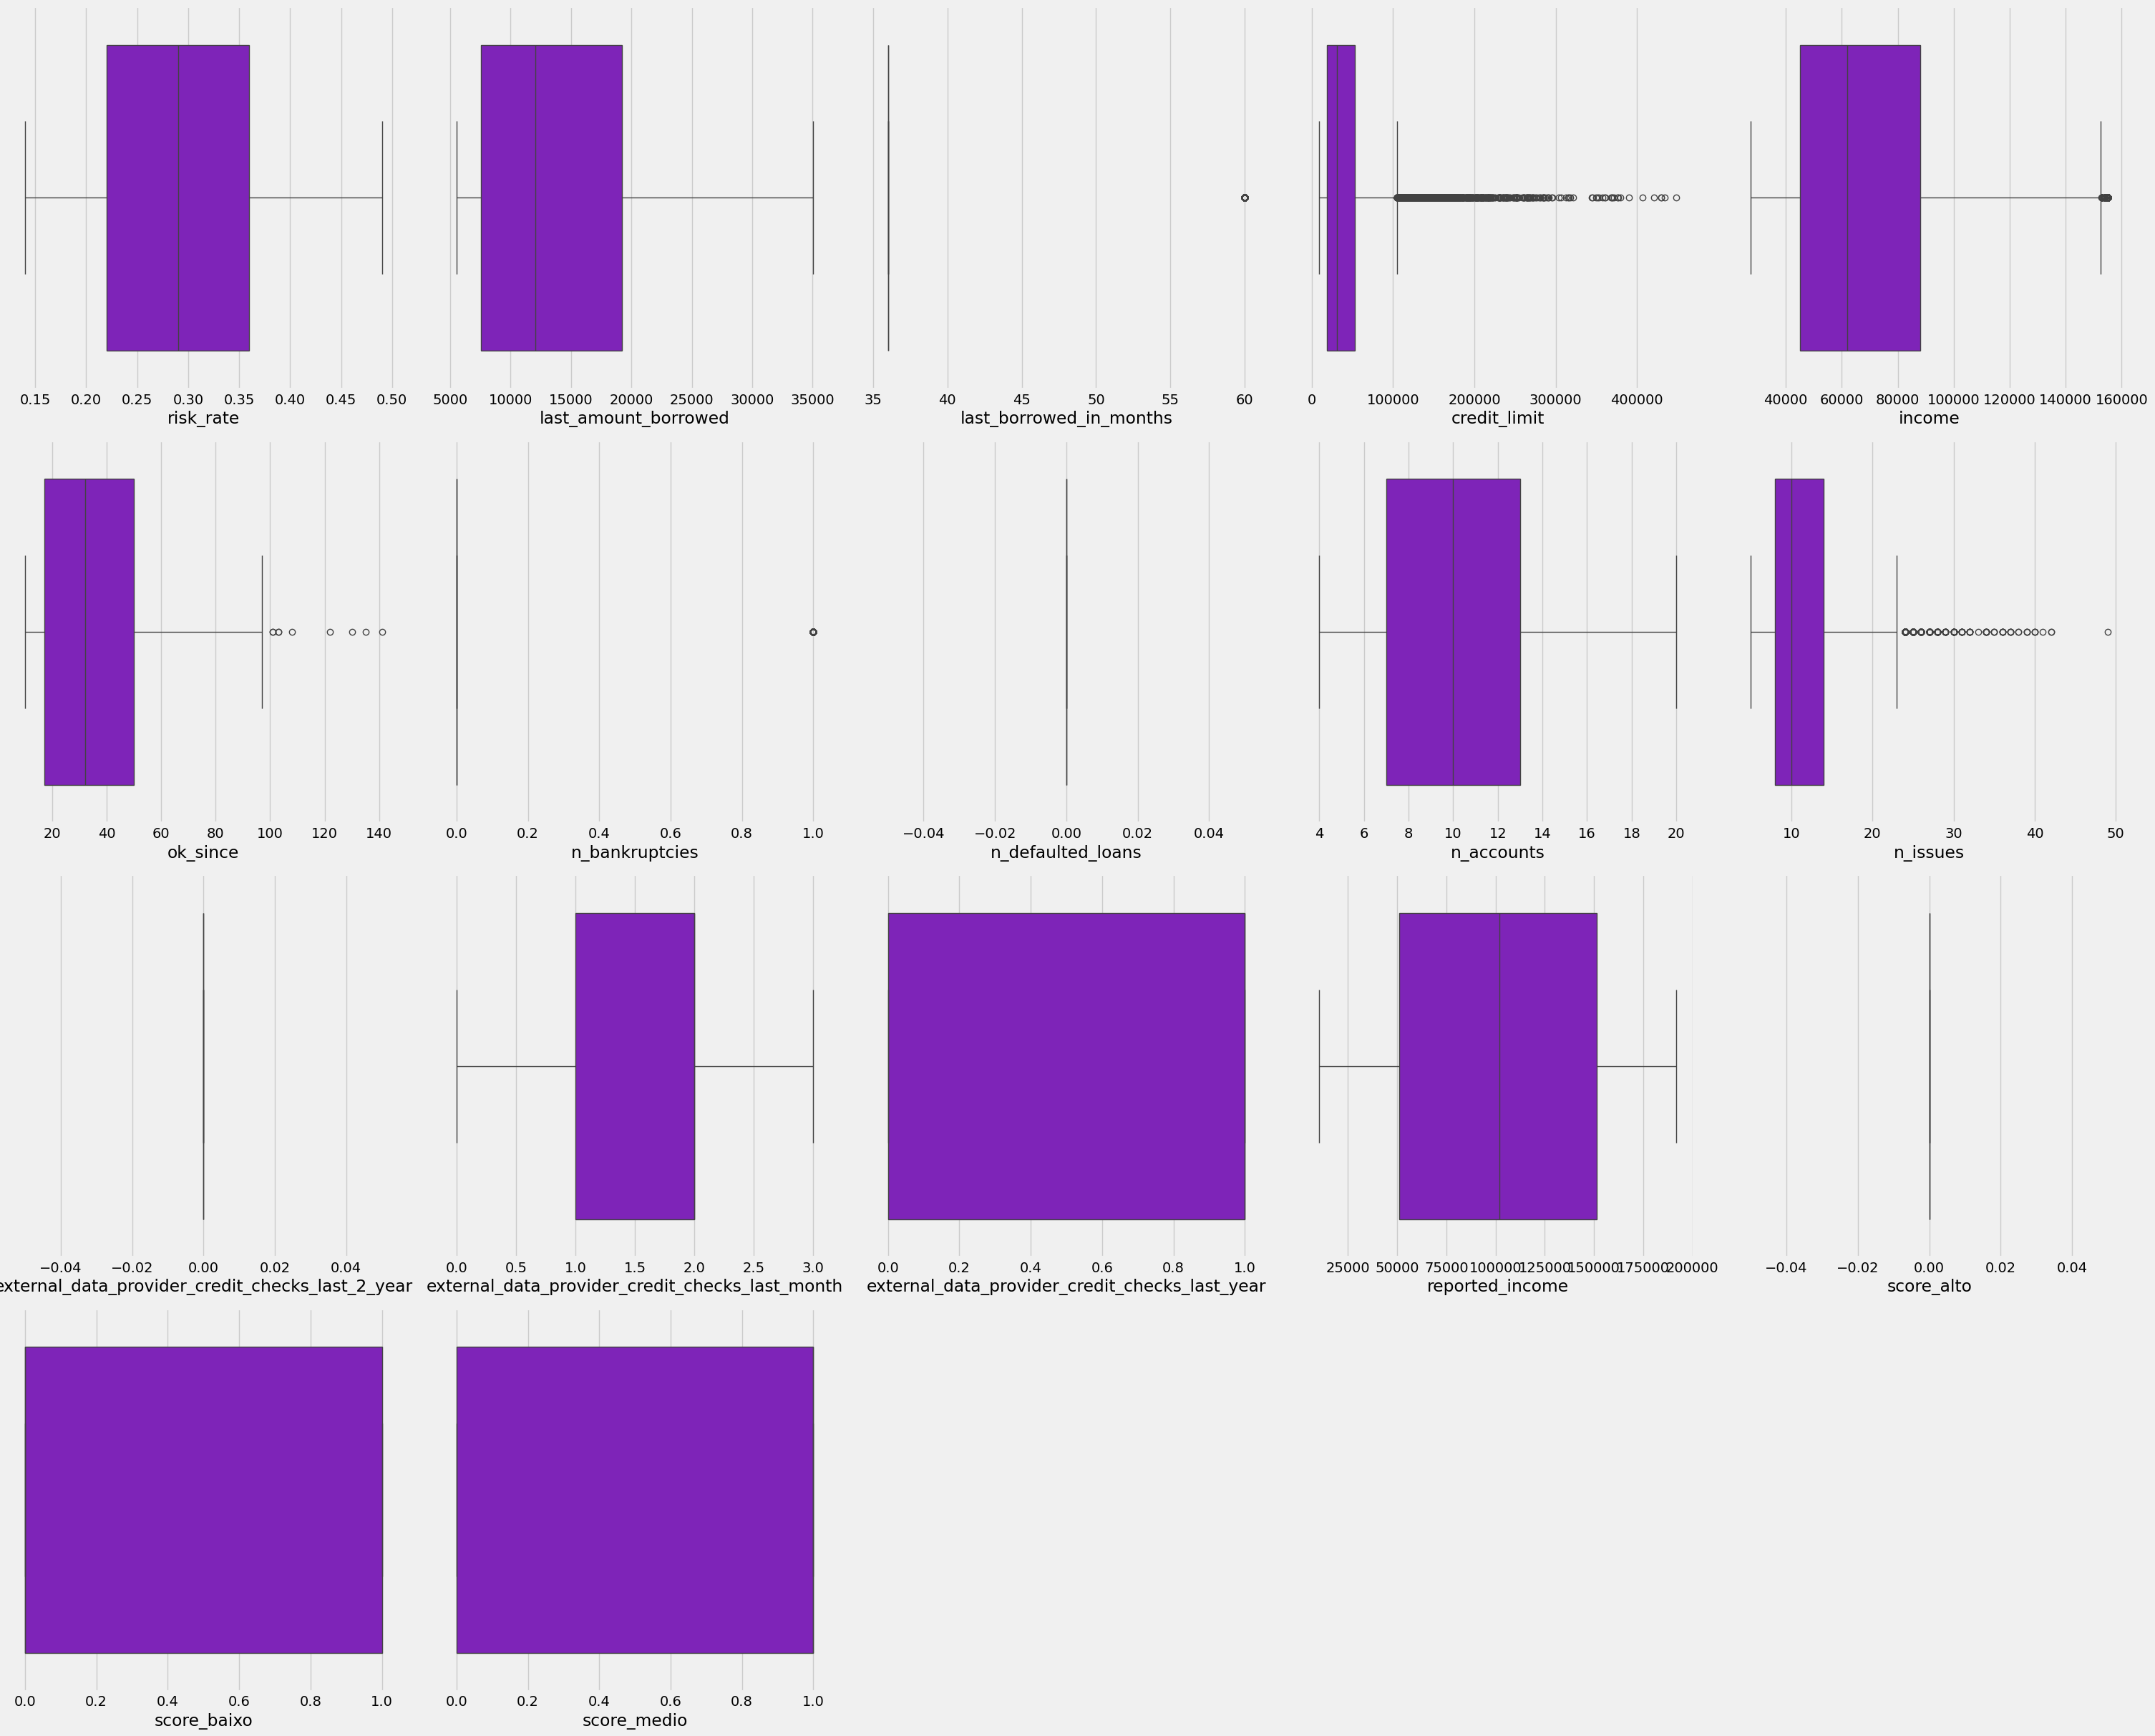

In [23]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(X):
    plt.subplot(5,5,index+1)
    sns.boxplot(data=X_winsorized,x=column, color="#830BD1")
    
plt.tight_layout(pad = 1.0)

## Describe entre X e X_winsorized para comparação

In [24]:
X.describe()

,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score_alto,score_baixo,score_medio
count,"44,438.00","15,044.00","15,044.00","25,930.00","44,438.00","18,455.00","44,303.00","44,426.00","44,438.00","33,456.00","22,372.00","45,000.00","29,876.00","44,933.00","45,000.00","45,000.00","45,000.00"
mean,0.30,"13,782.34",41.76,"41,369.72","71,607.39",35.07,0.08,0.00,10.70,11.07,0.00,1.50,0.50,"10,325,415,545,677.84",0.00,0.36,0.62
std,0.10,"8,077.57",10.25,"36,353.57","51,858.97",21.66,0.27,0.08,4.59,4.60,0.00,1.11,0.50,"255,964,775,525,338.34",0.05,0.48,0.48
min,0.00,"1,005.18",36.00,300.00,"4,821.18",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,403.00,0.00,0.00,0.00
25%,0.22,"7,519.50",36.00,"18,458.50","45,010.78",17.00,0.00,0.00,7.00,8.00,0.00,1.00,0.00,"50,856.00",0.00,0.00,0.00
50%,0.29,"12,023.47",36.00,"31,424.00","61,266.76",32.00,0.00,0.00,10.00,10.00,0.00,2.00,1.00,"101,630.00",0.00,0.00,1.00
75%,0.36,"19,220.27",36.00,"53,041.50","86,019.23",50.00,0.00,0.00,13.00,14.00,0.00,2.00,1.00,"151,187.00",0.00,1.00,1.00
max,0.90,"35,059.60",60.00,"448,269.00","5,000,027.83",141.00,5.00,5.00,49.00,49.00,0.00,3.00,1.00,"6,355,500,000,111,444.00",1.00,1.00,1.00


In [25]:
X_winsorized.describe()

,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score_alto,score_baixo,score_medio
count,"45,000.00","15,044.00","15,044.00","25,930.00","45,000.00","18,455.00","45,000.00","45,000.00","45,000.00","33,456.00","22,372.00","45,000.00","29,876.00","45,000.00","45,000.00","45,000.00","45,000.00"
mean,0.30,"14,048.12",41.76,"41,672.68","70,314.73",35.54,0.09,0.00,10.72,11.12,0.00,1.50,0.50,"101,297.66",0.00,0.36,0.62
std,0.10,"7,751.23",10.25,"36,064.91","33,960.72",21.04,0.28,0.00,4.30,4.52,0.00,1.11,0.50,"57,267.12",0.00,0.48,0.48
min,0.14,"5,517.47",36.00,"9,530.00","27,510.73",10.00,0.00,0.00,4.00,5.00,0.00,0.00,0.00,"10,453.00",0.00,0.00,0.00
25%,0.22,"7,519.50",36.00,"18,458.50","45,014.74",17.00,0.00,0.00,7.00,8.00,0.00,1.00,0.00,"50,948.25",0.00,0.00,0.00
50%,0.29,"12,023.47",36.00,"31,424.00","62,024.09",32.00,0.00,0.00,10.00,10.00,0.00,2.00,1.00,"101,779.00",0.00,0.00,1.00
75%,0.36,"19,220.27",36.00,"53,041.50","88,020.74",50.00,0.00,0.00,13.00,14.00,0.00,2.00,1.00,"151,337.25",0.00,1.00,1.00
max,0.49,"35,059.60",60.00,"448,269.00","155,022.28",141.00,1.00,0.00,20.00,49.00,0.00,3.00,1.00,"191,772.00",0.00,1.00,1.00


- Média (mean):

  - reported_income
  - Antes: Mais de 10.3 trilhões, claramente um erro ou outlier absurdo.
  - Depois: 101,297.66, um valor muito mais razoável para renda relatada.
- Isso sugere que havia valores extremamente altos no reported_income, que foram ajustados para reduzir a influência desses outliers.

- Desvio padrão (std):

  - O reported_income tinha um desvio padrão gigantesco (cerca de 255 quatrilhões antes da winsorização), que caiu drasticamente para 57.267 depois.
  - Isso mostra que a winsorização reduziu a variabilidade ao cortar valores extremos.

- Mínimo e Máximo (min e max):

  - reported_income: Antes, o máximo era um número gigantesco (6,35 quatrilhões), depois caiu para 191.772, um valor realista.
  - risk_rate: O valor máximo caiu de 0.90 para 0.49, indicando que os riscos muito altos foram limitados.
  - n_accounts: O máximo era 49 antes e caiu para 20, reduzindo os casos com um número excessivamente alto de contas.

## Train Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y, test_size=0.2,random_state=42)

# Pré-Processamento

## Preencher valores ausentes em X_train e X_test

In [27]:
# Preencher valores ausentes em X_train e X_test com a média de X_train
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)  # Usar a média de X_train para X_test

## Preencher valores ausentes em y_train e y_test

In [28]:
# Preencher valores ausentes em y_train e y_test com a mediana
y_train.fillna(y_train.median(), inplace=True)
y_test.fillna(y_train.median(), inplace=True)  # Usar a mediana de y_train para y_test

## Divisão das variáveis numéricas e categóricas

In [29]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
categorical_features = X_train.select_dtypes('object').columns.to_list()

- Número de linhas e colunas de cada treino e teste criados

In [30]:
print(f'Train shape: {X_train.shape}.')
print(f'Train target shape: {y_train.shape}.')
print(f'Test predictor shape: {X_test.shape}.')
print(f'Test target shape: {y_test.shape}.')

Train shape: (36000, 17).
Train target shape: (36000,).
Test predictor shape: (9000, 17).
Test target shape: (9000,).


## Concatenação de X_train e y_train

**Na célula a seguir, foi feita uma concatenação de **X_train** e **y_train** para uma nova variável para que seja possível fazer mais estimações.**

In [31]:
train_concat = pd.concat([X_train, y_train], axis=1)
train_concat.reset_index(drop=True, inplace=True)
train_concat.head()

,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score_alto,score_baixo,score_medio,target_default
0,0.17,"14,081.89",41.85,"32,451.00","95,035.02",35.48,0.00,0.00,7.00,7.00,0.00,0,0.00,"20,125.00",0.00,0.00,1.00,0
1,0.23,"14,081.89",41.85,"41,632.30","86,026.89",35.48,0.00,0.00,8.00,11.13,0.00,1,0.50,"24,460.00",0.00,0.00,1.00,0
2,0.40,"14,081.89",41.85,"41,632.30","45,042.92",35.48,0.00,0.00,4.00,11.13,0.00,2,1.00,"144,703.00",0.00,1.00,0.00,0
3,0.28,"14,081.89",41.85,"41,632.30","74,039.33",35.48,0.00,0.00,7.00,11.13,0.00,2,1.00,"186,114.00",0.00,1.00,0.00,0
4,0.22,"6,029.18",36.00,"41,632.30","55,026.98",35.48,0.00,0.00,9.00,11.13,0.00,0,0.50,"98,152.00",0.00,1.00,0.00,0


# Multicolinearidade

Multicolinearidade é uma condição em que duas ou mais variáveis independentes em um modelo de regressão estão fortemente correlacionadas. Isso significa que as variáveis fornecem informações redundantes sobre o que estão tentando prever, dificultando a análise da influência individual de cada variável no modelo.

O problema da Multicolinearidade ocorre quando há correlações muito elevadas entre variáveis explicativas e, em casos extremos, tais correlações podem ser perfeitas, indicando uma relação linear entre as variáveis.

Uma das principais causas da multicolinearidade é a existência de variáveis que apresentam a mesma tendência durante alguns períodos.

Para identificar a Multicolinearidade podemos usar o Coeficiente de Correlação de Pearson, mas há também o VIF (Variance Inflation Factor).

O VIF mede o quanto a variância do coeficiente de uma variável aumenta devido à multicolinearidade. Valores acima de 5 (ou 10, dependendo do contexto) indicam problemas.

**Interpretação dos Valores de VIF**

**VIF**=1 -> Sem colinearidade

1<**VIF**≤5 -> Colinearidade moderada (normalmente aceitável)

**VIF**>5 -> Colinearidade alta (potencial problema, investigar)

**VIF**>10 -> Colinearidade severa (geralmente inaceitável, ajustar o modelo)

## VIF

In [32]:
vif_data = pd.DataFrame()
vif_data["Feature"] = train_concat.columns
  
vif_data["VIF"] = [variance_inflation_factor(train_concat.values, i)
                          for i in range(len(train_concat.columns))]
print(vif_data.sort_values(by=['VIF'], ascending=False))

                                             Feature   VIF
2                            last_borrowed_in_months 49.37
9                                           n_issues 32.55
8                                         n_accounts 26.34
16                                       score_medio 25.03
15                                       score_baixo 14.64
1                               last_amount_borrowed 14.16
0                                          risk_rate 10.42
5                                           ok_since  7.60
4                                             income  6.76
13                                   reported_income  4.06
3                                       credit_limit  3.90
11   external_data_provider_credit_checks_last_month  2.79
12    external_data_provider_credit_checks_last_year  2.51
17                                    target_default  1.20
6                                     n_bankruptcies  1.19
7                                  n_defaulted_loans   N

## Análise do VIF (Variance Inflation Factor)



O **VIF** mede a multicolinearidade entre variáveis. Valores acima de **10** indicam um alto grau de colinearidade, o que pode impactar negativamente a estabilidade dos coeficientes em modelos estatísticos, como regressões.

### Principais Considerações

#### Multicolinearidade Grave  
As variáveis abaixo apresentam **valores extremamente altos**, sugerindo forte redundância. Isso pode indicar que algumas delas são altamente correlacionadas entre si e podem ser removidas ou combinadas.

- `last_borrowed_in_months` (**VIF = 49.37**)  
- `n_issues` (**VIF = 32.55**)  
- `n_accounts` (**VIF = 26.34**)  
- `score_medio` (**VIF = 25.03**)  

#### Multicolinearidade Significativa  
Essas variáveis também possuem VIF elevado e devem ser analisadas com atenção.

- `score_baixo` (**VIF = 14.64**)  
- `last_amount_borrowed` (**VIF = 14.16**)  
- `risk_rate` (**VIF = 10.42**)  

#### Variáveis com VIF Moderado/Baixo  
Essas variáveis apresentam **níveis aceitáveis** de colinearidade.

- `ok_since` (**VIF = 7.60**)  
- `income` (**VIF = 6.76**)  
- `reported_income` (**VIF = 4.06**)  
- `credit_limit` (**VIF = 3.90**)  
- `external_data_provider_credit_checks_last_month` (**VIF = 2.79**)  
- `external_data_provider_credit_checks_last_year` (**VIF = 2.51**)  

#### Variáveis sem VIF calculado (`NaN`)  
- `n_defaulted_loans`  
- `external_data_provider_credit_checks_last_2_year`  
- `score_alto`  

Isso pode ocorrer por alguns motivos:
- A variável pode ter valores constantes (sem variação).
- Pode haver dados ausentes.
- Pode ser uma variável dependente na análise.

### Recomendações  
 - **Remover ou transformar** variáveis com VIF muito alto (acima de 10). Uma abordagem comum é excluir uma das variáveis altamente correlacionadas ou aplicar técnicas como PCA (Análise de Componentes Principais).



# PCA

O PCA (Principal Component Analysis) é uma técnica de redução de dimensionalidade usada para identificar padrões em dados e reduzir o número de variáveis, mantendo a maior quantidade possível de informação. Ele transforma um conjunto de variáveis correlacionadas em um conjunto de variáveis não correlacionadas, chamadas de componentes principais. O objetivo é condensar a variabilidade dos dados em um número menor de variáveis, o que facilita a análise, preservando a maior parte da informação original.

Quando o VIF (Variance Inflation Factor) é alto, isso indica que há multicolinearidade entre as variáveis independentes, o que pode afetar a precisão das estimativas do modelo. O PCA pode ser uma boa solução nesse caso, pois ele combina as variáveis correlacionadas em componentes principais, eliminando a multicolinearidade e possibilitando uma análise mais robusta.

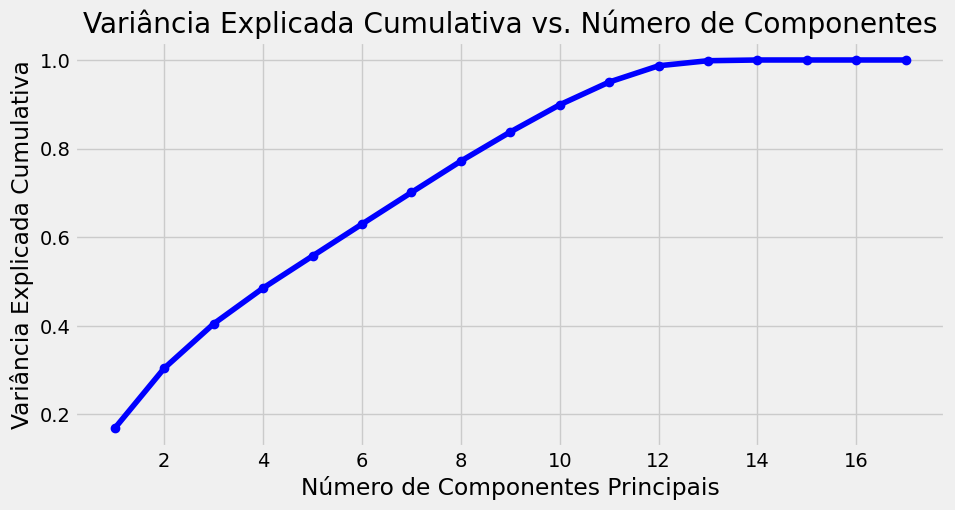

Número de componentes para explicar 95% da variância: 11
Loadings (Correlação entre variáveis originais e componentes principais):
                                                   PC1   PC2   PC3   PC4  \
risk_rate                                         0.08 -0.05  0.21  0.61   
last_amount_borrowed                              0.19 -0.24  0.58 -0.14   
last_borrowed_in_months                           0.13 -0.15  0.63 -0.05   
credit_limit                                      0.30 -0.18 -0.08 -0.15   
income                                            0.22 -0.40  0.08  0.04   
ok_since                                         -0.03  0.06 -0.03  0.14   
n_bankruptcies                                   -0.02 -0.06 -0.03  0.74   
n_defaulted_loans                                -0.00 -0.00  0.00 -0.00   
n_accounts                                        0.51 -0.23 -0.28  0.09   
n_issues                                          0.49 -0.21 -0.32 -0.05   
external_data_provider_credit_che

In [33]:
# Separar as variáveis independentes (features) do target 
X = train_concat.iloc[:, :-1]  
y = train_concat.iloc[:, -1]   

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explicação da variância
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plotar a variância explicada cumulativa para escolher o número de componentes
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Explicada Cumulativa vs. Número de Componentes')
plt.grid(True)
plt.show()

# Escolha o número de componentes com base na variância explicada
# Por exemplo, escolher o número de componentes que explicam 95% da variância
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"Número de componentes para explicar 95% da variância: {n_components}")

# Aplicar PCA novamente com o número de componentes escolhido
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Criar DataFrame com os componentes principais
columns = ['PC' + str(i) for i in range(1, n_components + 1)]
X_pca_df = pd.DataFrame(X_pca, columns=columns)

# Visualizar a contribuição das variáveis originais para os componentes principais
loadings = pd.DataFrame(pca.components_.T, columns=columns, index=X.columns)
print("Loadings (Correlação entre variáveis originais e componentes principais):")
print(loadings)

# Concatenar os componentes principais com o target
data_with_pca = pd.concat([X_pca_df, y], axis=1)
print("\nDataset com Componentes Principais:")
print(data_with_pca.head())


In [34]:
data_with_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,target_default
0,-0.42,1.10,0.55,-1.14,-0.94,-1.49,-1.46,0.02,0.96,-0.83,-0.84,0
1,0.32,0.85,0.23,-0.75,-0.29,-0.89,-0.61,0.89,0.52,-0.35,-0.39,0
2,-1.87,-0.82,0.31,0.28,0.55,1.24,0.55,0.43,-0.31,1.15,0.75,0
3,-1.42,-1.25,-0.07,-0.34,0.89,1.65,0.73,-0.09,0.19,0.24,0.22,0
4,-1.85,-0.55,-2.07,-0.60,-0.15,0.29,-1.25,-0.10,0.03,0.08,0.47,0


### Correlação PCA

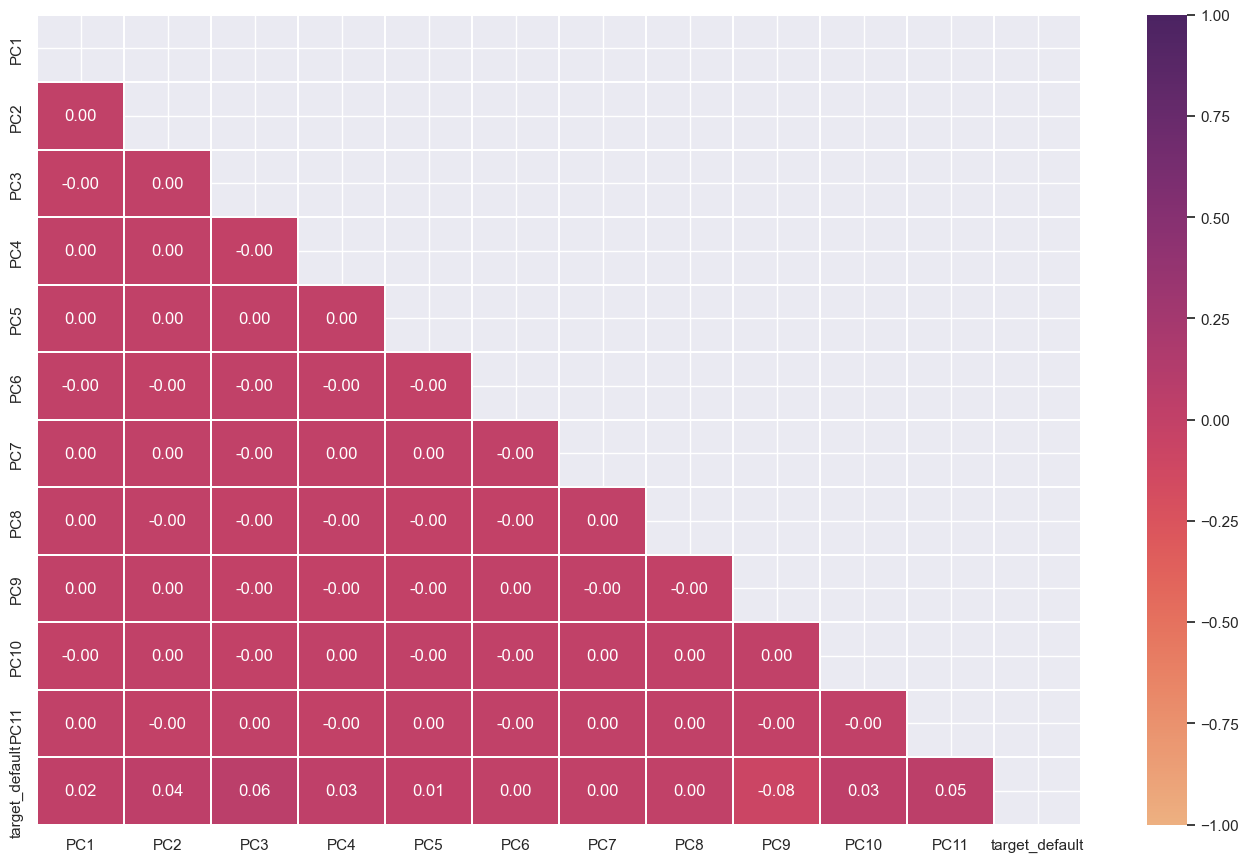

In [35]:
sns.set(font_scale=1)
matrix = np.triu(data_with_pca.corr())
plt.figure(figsize=(15, 10))
sns.heatmap(data_with_pca.corr(), annot = True, 
            cmap = 'flare', fmt=".2f", 
            mask = matrix, vmin = -1, vmax = 1, 
            linewidths = 0.1, linecolor = 'white')
plt.show()

##  Relatório de Análise de Componentes Principais (PCA)


### Número de Componentes Principais (PCs)
Foram necessários 11 componentes principais para explicar 95% da variância dos dados. Isso indica que há alta dimensionalidade nos dados, mas conseguimos reduzir significativamente o número de variáveis sem perder muita informação.

### Loadings (Correlação entre variáveis originais e PCs)

- **PC1** (Primeiro Componente Principal) tem forte relação positiva com **n_accounts (0.51)** e **n_issues (0.49)**, sugerindo que esses fatores são importantes para a variabilidade dos dados.
- **PC2** está altamente correlacionado com **score_medio (0.57)** e **score_baixo (-0.54)**, indicando que ele pode capturar informações relacionadas ao perfil de crédito dos clientes.
- **PC3** tem alta correlação com **last_amount_borrowed (0.58)** e **last_borrowed_in_months (0.63)**, sugerindo que ele reflete o comportamento recente de empréstimos.
- **PC4** mostra forte correlação com **risk_rate (0.61)** e **n_bankruptcies (0.74)**, o que sugere que este componente está fortemente ligado ao risco de inadimplência.
- **PC5-PC11** capturam informações menos óbvias, mas ainda são relevantes para explicar a variação nos dados.

#### Interpretação dos Componentes

- **PC1** captura informações sobre o número de contas e questões financeiras.
- **PC2** representa características de pontuação de crédito.
- **PC3** reflete informações sobre empréstimos anteriores.
- **PC4** está fortemente ligado ao risco de crédito.
- **PC5-PC11** capturam padrões mais sutis, incluindo histórico financeiro e consultas de crédito.

### Dataset com Componentes Principais

- Os novos dados agora estão representados em termos dos 11 componentes principais, que são combinações das variáveis originais.

- A variável-alvo (target_default) está presente, o que indica que essa transformação pode ser usada para modelagem preditiva.

### Conclusão

- O PCA foi eficiente em reduzir a dimensionalidade do dataset de forma significativa.

- Os primeiros componentes principais já capturam a maior parte da variação dos dados e podem ser usados para análises de risco de crédito.

- Esse dataset transformado pode ser utilizado para modelagem preditiva, como regressão logística ou modelos de machine learning, sem a multicolinearidade das variáveis originais.


# Estimação do Modelo Logístico Binário pela função "smf.glm"

A função **smf.glm** faz parte da biblioteca **statsmodels** em Python, que é amplamente utilizada para modelagem estatística. smf.glm é usada para ajustar **modelos lineares generalizados** (GLM, do inglês Generalized Linear Models).

O que são Modelos Lineares Generalizados (GLM)?

Os GLMs são uma extensão dos modelos lineares tradicionais que permitem modelar relações entre variáveis dependentes e independentes, mesmo quando a variável dependente não segue uma distribuição normal. Eles são úteis para situações em que:

- A variável dependente é binária (por exemplo, sucesso/falha).

- A variável dependente é contagem (por exemplo, número de eventos).

- A variável dependente segue outras distribuições, como Poisson, Binomial, Gamma, etc.

Quando usar smf.glm?

- Quando você precisa de flexibilidade para modelar diferentes tipos de variáveis dependentes.

- Quando os pressupostos de um modelo linear tradicional (como normalidade dos resíduos) não são atendidos.

- Para problemas de classificação, regressão de contagem, ou outros casos em que a variável dependente não é contínua.

Portanto o smf.glm é uma ferramenta poderosa para modelagem estatística em Python, especialmente quando se lida com dados que não seguem uma distribuição normal.

## Estimação do Modelo Logístico Binário 

In [36]:
modeldata_with_pca = smf.glm(
    formula='target_default ~ PC1 +  PC2 +  PC3 +  PC4 +  PC5 +  PC6 +  PC7 +  PC8 +  PC9 +  PC10 + PC11',
    data=data_with_pca,family=sm.families.Binomial()).fit()

In [37]:
print(modeldata_with_pca.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         target_default   No. Observations:                36000
Model:                            GLM   Df Residuals:                    35988
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14886.
Date:                Wed, 19 Mar 2025   Deviance:                       29772.
Time:                        21:52:54   Pearson chi2:                 3.59e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01626
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7843      0.015   -116.124      0.0

## Interpretação da Tabela de Resultados do Modelo Logístico Binário - GLM

### Introdução
Este relatório apresenta os resultados de uma regressão logística (Generalized Linear Model - GLM) aplicada a um conjunto de dados com 36.000 observações. O objetivo do modelo é prever a variável dependente `target_default`, que é binária (0 ou 1). O modelo utiliza 11 variáveis explicativas (PC1 a PC11) e foi ajustado utilizando a função de ligação logit.

### Resumo do Modelo

- **Variável Dependente**: `target_default`
- **Número de Observações**: 36.000
- **Família do Modelo**: Binomial (regressão logística)
- **Função de Ligação**: Logit
- **Método de Ajuste**: IRLS (Iteratively Reweighted Least Squares)
- **Log-Likelihood**: -14.886
- **Deviance**: 29.772
- **Pseudo R² (Cox & Snell)**: 0.01626
- **Número de Iterações**: 5

### Resultados dos Coeficientes

| Variável   | Coeficiente | Erro Padrão | Estatística Z | P-valor | Intervalo de Confiança (95%) |
|------------|-------------|-------------|---------------|---------|------------------------------|
| Intercept  | -1.7843     | 0.015       | -116.124      | 0.000   | [-1.814, -1.754]             |
| PC1        | 0.0276      | 0.010       | 2.803         | 0.005   | [0.008, 0.047]               |
| PC2        | 0.0845      | 0.011       | 7.585         | 0.000   | [0.063, 0.106]               |
| PC3        | 0.1297      | 0.012       | 10.969        | 0.000   | [0.106, 0.153]               |
| PC4        | 0.0791      | 0.014       | 5.502         | 0.000   | [0.051, 0.107]               |
| PC5        | 0.0250      | 0.015       | 1.685         | 0.092   | [-0.004, 0.054]              |
| PC6        | 0.0136      | 0.015       | 0.917         | 0.359   | [-0.016, 0.043]              |
| PC7        | 0.0012      | 0.015       | 0.081         | 0.935   | [-0.028, 0.030]              |
| PC8        | 0.0097      | 0.015       | 0.649         | 0.516   | [-0.020, 0.039]              |
| PC9        | -0.2432     | 0.016       | -14.931       | 0.000   | [-0.275, -0.211]             |
| PC10       | 0.1005      | 0.016       | 6.253         | 0.000   | [0.069, 0.132]               |
| PC11       | 0.1710      | 0.018       | 9.320         | 0.000   | [0.135, 0.207]               |

### Análise dos Coeficientes

1. **Intercepto**: O valor negativo do intercepto (-1.7843) indica que, na ausência de todas as variáveis explicativas, a probabilidade de `target_default` ser 1 é baixa.
2. **Variáveis Significativas**:
   - **PC1, PC2, PC3, PC4, PC9, PC10, PC11**: Essas variáveis apresentam coeficientes estatisticamente significativos (p-valor < 0.05), indicando que têm impacto na predição de `target_default`.
   - **PC5, PC6, PC7, PC8**: Essas variáveis não são estatisticamente significativas (p-valor > 0.05), sugerindo que não contribuem significativamente para o modelo.
3. **Magnitude dos Coeficientes**:
   - **PC9** tem o maior impacto negativo (-0.2432), reduzindo a probabilidade de `target_default`.
   - **PC11** tem o maior impacto positivo (0.1710), aumentando a probabilidade de `target_default`.

### Avaliação do Modelo

- **Pseudo R² (Cox & Snell)**: O valor de 0.01626 indica que o modelo explica uma pequena proporção da variabilidade dos dados. Isso sugere que o modelo pode não ser muito robusto para prever `target_default`.
- **Log-Likelihood**: O valor negativo elevado (-14.886) sugere que o ajuste do modelo pode não ser ideal.
- **Deviance**: Um valor alto (29.772) também indica que o modelo pode não estar capturando adequadamente a variabilidade dos dados.

### Conclusão

O modelo de regressão logística ajustado apresenta algumas limitações, como um baixo poder explicativo (Pseudo R²) e variáveis não significativas (PC5 a PC8). No entanto, as variáveis PC1, PC2, PC3, PC4, PC9, PC10 e PC11 são estatisticamente significativas e contribuem para a predição de `target_default`. Recomenda-se a revisão do conjunto de dados e a inclusão de novas variáveis ou transformações para melhorar o desempenho do modelo.

# Likelihood Ratio Test (LRT)

O **Likelihood Ratio Test (LRT)** é usado para comparar dois modelos aninhados (um modelo completo e um modelo reduzido) para determinar se a inclusão de variáveis adicionais no modelo completo melhora significativamente o ajuste. No contexto do resultado do Modelo Logístico Binário - GLM criado, poderemos comparar o modelo atual (com todas as variáveis) com um modelo reduzido (excluindo algumas variáveis, como as não significativas: PC5, PC6, PC7, PC8).


### Passos para Realizar o LRT

- Ajustar o Modelo Completo: O modelo que já foi ajustado no relatório.

- Ajustar o Modelo Reduzido: Um modelo sem as variáveis que você deseja testar (por exemplo, PC5, PC6, PC7, PC8).

- Calcular a Estatística do Teste: A estatística do LRT é dada por:

$$LRT=−2×(Log-Likelihood do Modelo Reduzido−Log-Likelihood do Modelo Completo)$$


- Determinar o Valor-p: A estatística do LRT segue uma distribuição qui-quadrado $(
χ
2)$ com graus de liberdade iguais à diferença no número de parâmetros entre os dois modelos.

In [38]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import chi2

# Ajustar o modelo completo
modelo_completo = sm.GLM(y, data_with_pca, family=sm.families.Binomial())
resultado_completo = modelo_completo.fit()

# Ajustar o modelo reduzido (excluindo PC5, PC6, PC7, PC8)
X_reduzido = data_with_pca.drop(columns=['PC5', 'PC6', 'PC7', 'PC8'])  # Remover variáveis não significativas
modelo_reduzido = sm.GLM(y, X_reduzido, family=sm.families.Binomial())
resultado_reduzido = modelo_reduzido.fit()

# Calcular a estatística do LRT
loglik_completo = resultado_completo.llf  # Log-Likelihood do modelo completo
loglik_reduzido = resultado_reduzido.llf  # Log-Likelihood do modelo reduzido
lrt_statistic = -2 * (loglik_reduzido - loglik_completo)  # Estatística do LRT

# Graus de liberdade (diferença no número de parâmetros)
df = resultado_completo.df_model - resultado_reduzido.df_model

# Calcular o valor-p
p_value = chi2.sf(lrt_statistic, df)  # Função de sobrevivência da distribuição qui-quadrado

# Exibir resultados
print(f"Estatística do LRT: {lrt_statistic}")
print(f"Graus de liberdade: {df}")
print(f"Valor-p: {p_value}")

Estatística do LRT: 0.6646130998851731
Graus de liberdade: 4
Valor-p: 0.9556200695565215


- Se o valor-p for alto (por exemplo, > 0.05), podemos considerar a remoção das variáveis não significativas para simplificar o modelo.

 - O valor-p ficou com 0.9556200695565215, o que é maior que 0.05. Portanto, não rejeitamos a hipótese nula e concluímos que as variáveis excluídas (PC5, PC6, PC7, PC8) não são estatisticamente significativas e devem ser removidas do modelo.

# Stepwise

## Método Stepwise em Análise de Regressão

O método **stepwise** é uma técnica utilizada em análise de regressão para selecionar variáveis independentes (ou preditores) que melhor explicam a variável dependente (ou resposta). Ele é comumente aplicado em modelos de regressão linear múltipla, mas também pode ser adaptado para outros tipos de modelos. O objetivo principal é construir um modelo estatístico que inclua apenas as variáveis mais relevantes, evitando a sobrecarga de preditores desnecessários, o que pode levar a:

- **Overfitting (sobreajuste)**: Quando o modelo se ajusta demais aos dados de treinamento, perdendo a capacidade de generalizar para novos dados.
- **Modelos menos interpretáveis**: A inclusão de muitas variáveis pode dificultar a interpretação dos resultados.

## Como Funciona o Stepwise?

O método **stepwise** automatiza a inclusão ou exclusão de preditores no modelo, com base em critérios estatísticos predefinidos. Ele é particularmente útil para:

1. Encontrar um **subconjunto ideal de variáveis explicativas**.
2. Evitar modelos excessivamente complexos ou irrelevantes.

## Tipos de Stepwise

Existem três abordagens principais no método stepwise:

1. **Forward Selection**: Inicia com um modelo vazio e adiciona variáveis uma a uma, com base em critérios estatísticos.
2. **Backward Elimination**: Começa com todas as variáveis no modelo e remove as menos significativas iterativamente.
3. **Stepwise Regression**: Combina as duas abordagens anteriores, permitindo a inclusão e exclusão de variáveis em cada etapa.

## Vantagens

- **Eficiência**: Automatiza o processo de seleção de variáveis, economizando tempo.
- **Simplicidade**: Gera modelos mais simples e interpretáveis.
- **Evita Overfitting**: Reduz o risco de incluir variáveis irrelevantes.

## Limitações

- **Dependência de Critérios Estatísticos**: A escolha dos critérios pode influenciar os resultados.
- **Risco de Exclusão de Variáveis Relevantes**: Em alguns casos, variáveis importantes podem ser excluídas devido a critérios rígidos.
- **Não Considera Interações Complexas**: Pode não capturar interações não lineares entre variáveis.

## Conclusão

O método stepwise é uma ferramenta valiosa para a seleção de variáveis em modelos de regressão, mas deve ser utilizado com cuidado, considerando suas limitações e o contexto do problema em questão.

In [39]:
stepwise_modeldata_with_pca = stepwise(modeldata_with_pca, pvalue_limit=0.05)

Regression type: GLM 

Estimating model...: 
 target_default ~ Q('PC1') + Q('PC2') + Q('PC3') + Q('PC4') + Q('PC5') + Q('PC6') + Q('PC7') + Q('PC8') + Q('PC9') + Q('PC10') + Q('PC11')

 Family type...: 
 Binomial

 Discarding atribute "Q('PC7')" with p-value equal to 0.9354799553596167 

Estimating model...: 
 target_default ~ Q('PC1') + Q('PC2') + Q('PC3') + Q('PC4') + Q('PC5') + Q('PC6') + Q('PC8') + Q('PC9') + Q('PC10') + Q('PC11')

 Family type...: 
 Binomial

 Discarding atribute "Q('PC8')" with p-value equal to 0.5165171589003634 

Estimating model...: 
 target_default ~ Q('PC1') + Q('PC2') + Q('PC3') + Q('PC4') + Q('PC5') + Q('PC6') + Q('PC9') + Q('PC10') + Q('PC11')

 Family type...: 
 Binomial

 Discarding atribute "Q('PC6')" with p-value equal to 0.3592015198378641 

Estimating model...: 
 target_default ~ Q('PC1') + Q('PC2') + Q('PC3') + Q('PC4') + Q('PC5') + Q('PC9') + Q('PC10') + Q('PC11')

 Family type...: 
 Binomial

 Discarding atribute "Q('PC5')" with p-value equal to 

## Relatório do Método Stepwise

### Introdução
Este relatório apresenta os resultados da análise de regressão utilizando um Modelo Linear Generalizado (GLM) com família Binomial e função de ligação Logit. O objetivo foi identificar quais variáveis preditoras PCA(componentes principais) têm um impacto significativo na variável dependente `target_default`.

### Metodologia
O modelo foi estimado utilizando um processo stepwise, onde variáveis com p-valor superior a 0.05 foram descartadas sequencialmente. O modelo final inclui apenas as variáveis que apresentaram significância estatística.

### Resultados

#### Variáveis Descartadas
Durante o processo de seleção de variáveis, as seguintes variáveis foram descartadas devido a p-valores elevados:

| Variável   | P-valor       |
|------------|---------------|
| Q('PC7')   | 0.93547995536 |
| Q('PC8')   | 0.51651715890 |
| Q('PC6')   | 0.35920151984 |
| Q('PC5')   | 0.09118859854 |

#### Modelo Final
O modelo final inclui as seguintes variáveis preditoras:

- Q('PC1')
- Q('PC2')
- Q('PC3')
- Q('PC4')
- Q('PC9')
- Q('PC10')
- Q('PC11')

#### Coeficientes do Modelo Final
A tabela abaixo apresenta os coeficientes estimados para cada variável no modelo final:

| Variável   | Coeficiente | Erro Padrão | Z-score | P-valor | Intervalo de Confiança (95%) |
|------------|-------------|-------------|---------|---------|------------------------------|
| Intercept  | -1.7840     | 0.015       | -116.135| 0.000   | [-1.814, -1.754]             |
| Q('PC1')   | 0.0279      | 0.010       | 2.838   | 0.005   | [0.009, 0.047]               |
| Q('PC2')   | 0.0842      | 0.011       | 7.564   | 0.000   | [0.062, 0.106]               |
| Q('PC3')   | 0.1299      | 0.012       | 10.985  | 0.000   | [0.107, 0.153]               |
| Q('PC4')   | 0.0790      | 0.014       | 5.502   | 0.000   | [0.051, 0.107]               |
| Q('PC9')   | -0.2428     | 0.016       | -14.937 | 0.000   | [-0.275, -0.211]             |
| Q('PC10')  | 0.1004      | 0.016       | 6.250   | 0.000   | [0.069, 0.132]               |
| Q('PC11')  | 0.1715      | 0.018       | 9.366   | 0.000   | [0.136, 0.207]               |

#### Métricas do Modelo
- **Número de Observações:** 36000
- **Log-Likelihood:** -14888
- **Deviance:** 29776
- **Pseudo R² (CS):** 0.01615

### Conclusão
O modelo final inclui sete variáveis preditoras que apresentaram significância estatística (p-valor < 0.05). As variáveis Q('PC3') e Q('PC11') foram as que tiveram os maiores impactos positivos na variável dependente, enquanto Q('PC9') teve um impacto negativo significativo. O modelo explica aproximadamente 1.6% da variabilidade dos dados (Pseudo R²), indicando que há outros fatores não incluídos no modelo que podem influenciar a variável dependente.

Recomenda-se a inclusão de outras variáveis ou a consideração de modelos mais complexos para melhorar a explicação da variabilidade dos dados.

## data_with_pca apenas com as variáveis preditoras que apresentaram significância estatística. **PC1, PC2, PC3, PC4, PC9, PC10, PC11** 

In [40]:
data_with_pca = data_with_pca.drop(columns=['PC5', 'PC6', 'PC7', 'PC8'], axis = 1)	

In [41]:
data_with_pca.head()

,PC1,PC2,PC3,PC4,PC9,PC10,PC11,target_default
0,-0.42,1.10,0.55,-1.14,0.96,-0.83,-0.84,0
1,0.32,0.85,0.23,-0.75,0.52,-0.35,-0.39,0
2,-1.87,-0.82,0.31,0.28,-0.31,1.15,0.75,0
3,-1.42,-1.25,-0.07,-0.34,0.19,0.24,0.22,0
4,-1.85,-0.55,-2.07,-0.60,0.03,0.08,0.47,0


# Criação da Feature "phat" com as probabilidades previstas pelo modelo

Este código está adicionando uma nova coluna ao DataFrame `train_smf_glm`, chamada **'phat'**, que contém as probabilidades previstas pelo modelo **GLM** para cada observação no conjunto de treinamento. Essas probabilidades podem ser utilizadas para análises posteriores, tais como:

- Avaliação do desempenho do modelo (por exemplo, cálculo da **curva ROC** ou **AUC**).
- Análise de classificação.

In [42]:
data_with_pca['phat'] = stepwise_modeldata_with_pca.predict()

## Visualizando phat com boxplot e describe

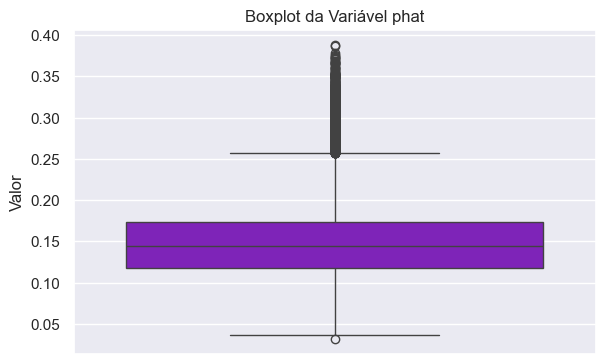

In [43]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=data_with_pca.phat, color='#830BD1')

plt.title('Boxplot da Variável phat')
plt.ylabel('Valor')

plt.show()

In [44]:
data_with_pca.phat.describe()

count   36,000.00
mean         0.15
std          0.05
min          0.03
25%          0.12
50%          0.14
75%          0.17
max          0.39
Name: phat, dtype: float64

- Podemos ver que 0.39 é o valor máximo gerado pela feature phat, média com 0.03 e mediana com 0.14.

# Cutoff

Na Regressão Logística, o **Cutoff** (ou ponto de corte) é um valor limite usado para classificar as probabilidades previstas pelo modelo em categorias discretas, como 0 ou 1 (em problemas de classificação binária). A regressão logística prevê a probabilidade de uma observação pertencer a uma classe (por exemplo, a classe 1), e o cutoff é o valor que define a partir de qual probabilidade a observação será classificada em uma classe ou outra.

**Como funciona o Cutoff na Regressão Logística?**

- Probabilidade prevista: O modelo de regressão logística gera uma probabilidade (entre 0 e 1) para cada observação, indicando a chance de pertencer à classe positiva (por exemplo, classe 1).

- Aplicação do Cutoff: Um valor de cutoff é escolhido (geralmente 0,5, mas pode variar) para transformar essa probabilidade em uma decisão binária:

  - Se a probabilidade for maior ou igual ao cutoff, a observação é classificada como classe 1.

  - Se a probabilidade for menor que o cutoff, a observação é classificada como classe 0.

Por exemplo:

- Se o cutoff for 0,5:

  - Probabilidade ≥ 0,5 → Classe 1

  - Probabilidade < 0,5 → Classe 0

**Impacto do Cutoff:**

- Um cutoff mais baixo (ex.: 0,3) torna o modelo mais "sensível", classificando mais observações como classe 1. Isso pode aumentar a taxa de verdadeiros positivos, mas também pode aumentar os falsos positivos.

- Um cutoff mais alto (ex.: 0,7) torna o modelo mais "conservador", classificando menos observações como classe 1. Isso pode reduzir os falsos positivos, mas também pode aumentar os falsos negativos.

**Escolha do Cutoff**

A escolha do cutoff ideal depende do contexto do problema e dos objetivos do modelo. Algumas abordagens comuns incluem:

- Cutoff padrão (0,5): Usado quando não há preferência específica entre sensibilidade e especificidade.

- Curva ROC e AUC: A Curva ROC (Receiver Operating Characteristic) ajuda a visualizar o desempenho do modelo em diferentes cutoffs. O ponto ideal é aquele que maximiza a sensibilidade e a especificidade.

- Maximização de métricas específicas: Dependendo do problema, pode-se escolher um cutoff que maximize métricas como F1-score, precisão ou sensibilidade.

- Custos associados a erros: Em problemas onde falsos positivos ou falsos negativos têm custos diferentes, o cutoff pode ser ajustado para minimizar o custo total.

## Matriz de Confusão para Cutoff de 0.20

A matriz de confusão é uma ferramenta utilizada em machine learning e estatística para avaliar o desempenho de modelos de classificação. Ela permite visualizar de forma clara os acertos e erros do modelo ao classificar os dados, comparando as previsões feitas pelo modelo com os valores reais (rótulos verdadeiros).

## Estrutura da Matriz de Confusão

Para um problema de classificação binária (duas classes, como "Positivo" e "Negativo"), a matriz de confusão é uma tabela 2x2 com a seguinte estrutura:

<div style="text-align: center;">
    <img src="../images/matriz_de_confusao.jpg" alt="Texto Alternativo" width="50%">
</div>

- Verdadeiro Positivo (VP): O modelo previu corretamente a classe positiva.

- Falso Positivo (FP): O modelo previu incorretamente a classe positiva (era negativo).

- Falso Negativo (FN): O modelo previu incorretamente a classe negativa (era positivo).

- Verdadeiro Negativo (VN): O modelo previu corretamente a classe negativa.

### Métricas derivadas da matriz de confusão

A matriz de confusão é usada para calcular métricas de avaliação, como:

- Acurácia: 
$\text{Acurácia} = \frac{VP + VN}{VP + FP + FN + VN}$
​
- Precisão: 
$\text{Precisão} = \frac{VP}{VP + FP}$
​
- Recall (Sensitividade): 
$\text{Recall} = \frac{VP}{VP + FN}$
​
- Especificidade: 
$\text{Especificidade} = \frac{VN}{VN + FP}$

- F1-Score: Média harmônica entre precisão e recall.

## Matriz de confusão para cutoff = 0.2

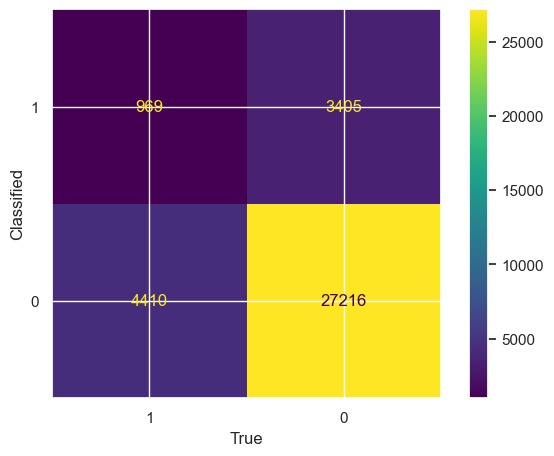

,Sensitividade,Especificidade,Acurácia
0,0.18,0.89,0.78


In [45]:
# Matriz de confusão para cutoff = 0.2
matriz_confusao(observado=data_with_pca['target_default'],
                predicts=data_with_pca['phat'], 
                cutoff=0.2)

### Dataframe que contém os vetores mencionados

In [46]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados (dataframe 'dados_plotagem')

dados_plotagem = espec_sens(observado = data_with_pca['target_default'],
                            predicts = data_with_pca['phat'])


In [47]:
dados_plotagem

,cutoffs,sensitividade,especificidade
0,0.00,1.00,0.00
1,0.01,1.00,0.00
2,0.02,1.00,0.00
3,0.03,1.00,0.00
4,0.04,1.00,0.00
5,0.05,1.00,0.00
6,0.06,1.00,0.00
7,0.07,0.99,0.02
8,0.08,0.98,0.04
9,0.09,0.97,0.08


### O que esses valores indicam sobre o modelo?|

- Baixa sensibilidade (0.18) → O modelo está falhando em detectar os positivos, indicando um alto número de falsos negativos.

- Alta especificidade (0.89) → O modelo acerta bem os negativos, errando poucos deles.

- Acurácia razoável (0.78), mas pode ser enganosa se houver desbalanceamento de classes.

### Gráfico que mostra a variação da especificidade e da sensitividade em função do cutoff

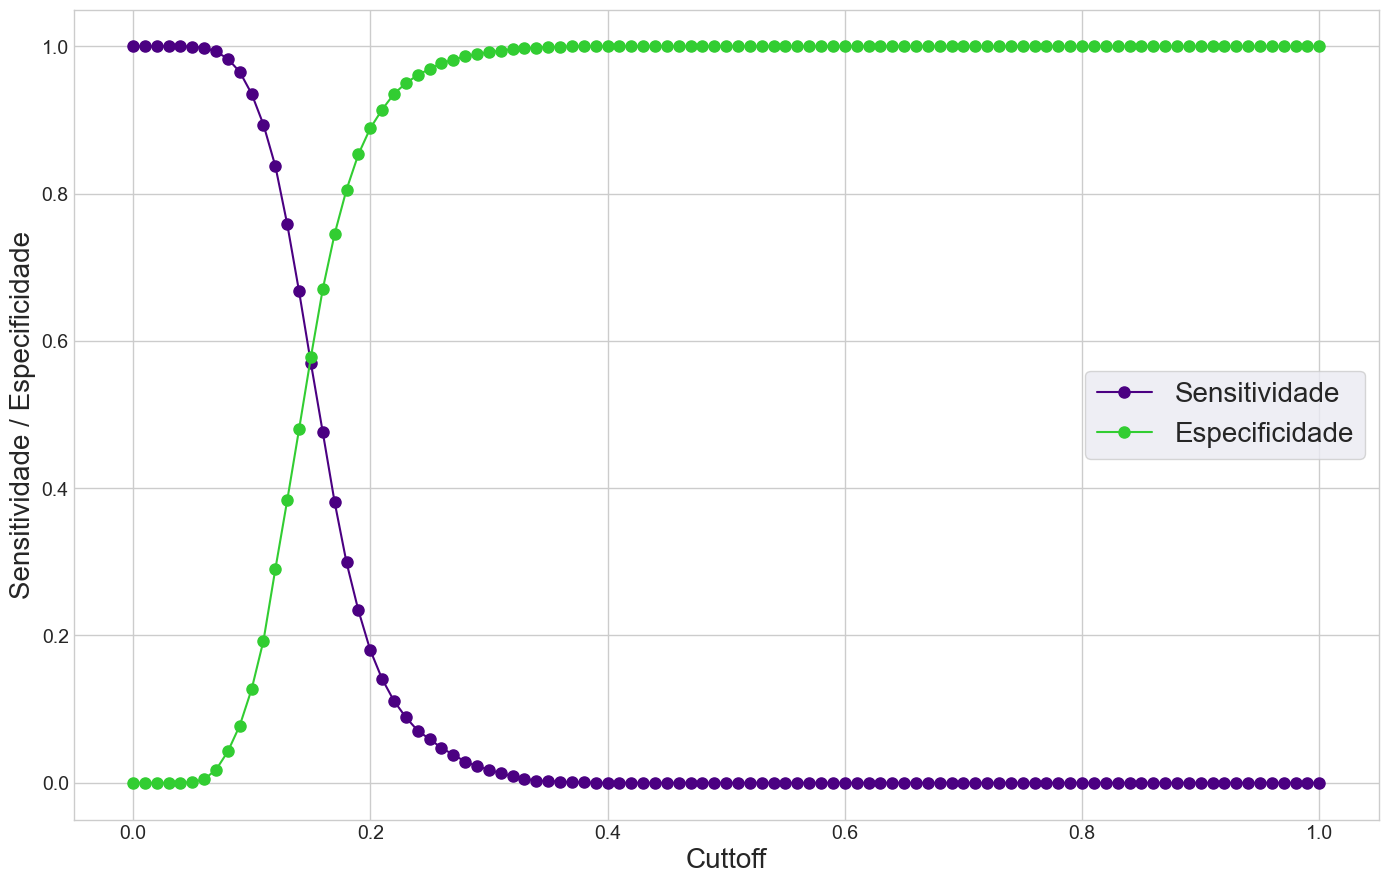

In [48]:
plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

### Possíveis soluções

- Alterar o threshold de classificação para aumentar a sensibilidade.
- Usar um modelo diferente, como árvores de decisão, Random Forest ou redes neurais, para melhorar a capacidade preditiva.
- Ajustar pesos na função de custo, dando mais importância para os casos positivos.

## Curva ROC

A **Curva ROC (Receiver Operating Characteristic)** é uma ferramenta gráfica usada para avaliar o desempenho de um modelo de classificação, especialmente em problemas binários (onde a variável dependente tem duas classes, como 0 e 1). Ela é amplamente utilizada para entender a relação entre a **taxa de verdadeiros positivos (Sensibilidade)** e a **taxa de falsos positivos (1 - Especificidade)** em diferentes pontos de corte (thresholds).

Na curva ROC (Receiver Operating Characteristic), o FPR e o TPR são métricas usadas para avaliar a performance de um modelo de classificação binária.

- TPR (True Positive Rate) - Taxa de Verdadeiros Positivos, também chamado de sensibilidade ou recall. Mede a proporção de exemplos positivos corretamente classificados.

- FPR (False Positive Rate) - Taxa de Falsos Positivos. Mede a proporção de exemplos negativos que foram incorretamente classificados como positivos.



### Como esses valores afetam a curva ROC?

- A curva ROC é um gráfico que mostra o TPR no eixo Y e o FPR no eixo X para diferentes limiares de decisão do modelo.

- Um bom modelo tende a ter um TPR alto e um FPR baixo, ou seja, a curva ROC deve estar próxima do canto superior esquerdo.

- O AUC (Área Sob a Curva) mede o desempenho global do modelo, sendo 1 um modelo perfeito e 0.5 equivalente a um modelo aleatório.

- Os thresholds (ou limiares) são os valores de corte (cutoff) usados pelo modelo de classificação para decidir se uma determinada predição pertence à classe positiva ou negativa.

### Objetivos ao Definir o Threshold

- Minimizar o risco de inadimplência

  - Se o banco quer reduzir ao máximo o crédito para clientes de alto risco, o threshold deve ser mais alto (exemplo: 0.7 ou 0.8).

  - Isso significa que o modelo só aprovará clientes com alta confiança de que pagarão o crédito.

  - Consequência: menos falsos positivos (FP, ou seja, menos concessões erradas), mas também pode rejeitar bons clientes.

- Aproveitar mais oportunidades de concessão de crédito

  - Se o banco quer aumentar a base de clientes e oferecer mais crédito, o threshold pode ser mais baixo (exemplo: 0.4 ou 0.5).

  - Isso aprova mais clientes, incluindo aqueles com um certo risco de inadimplência.

  - Consequência: mais falsos positivos (FP, ou seja, mais clientes podem não pagar), mas mais lucro com juros para aqueles que pagam.

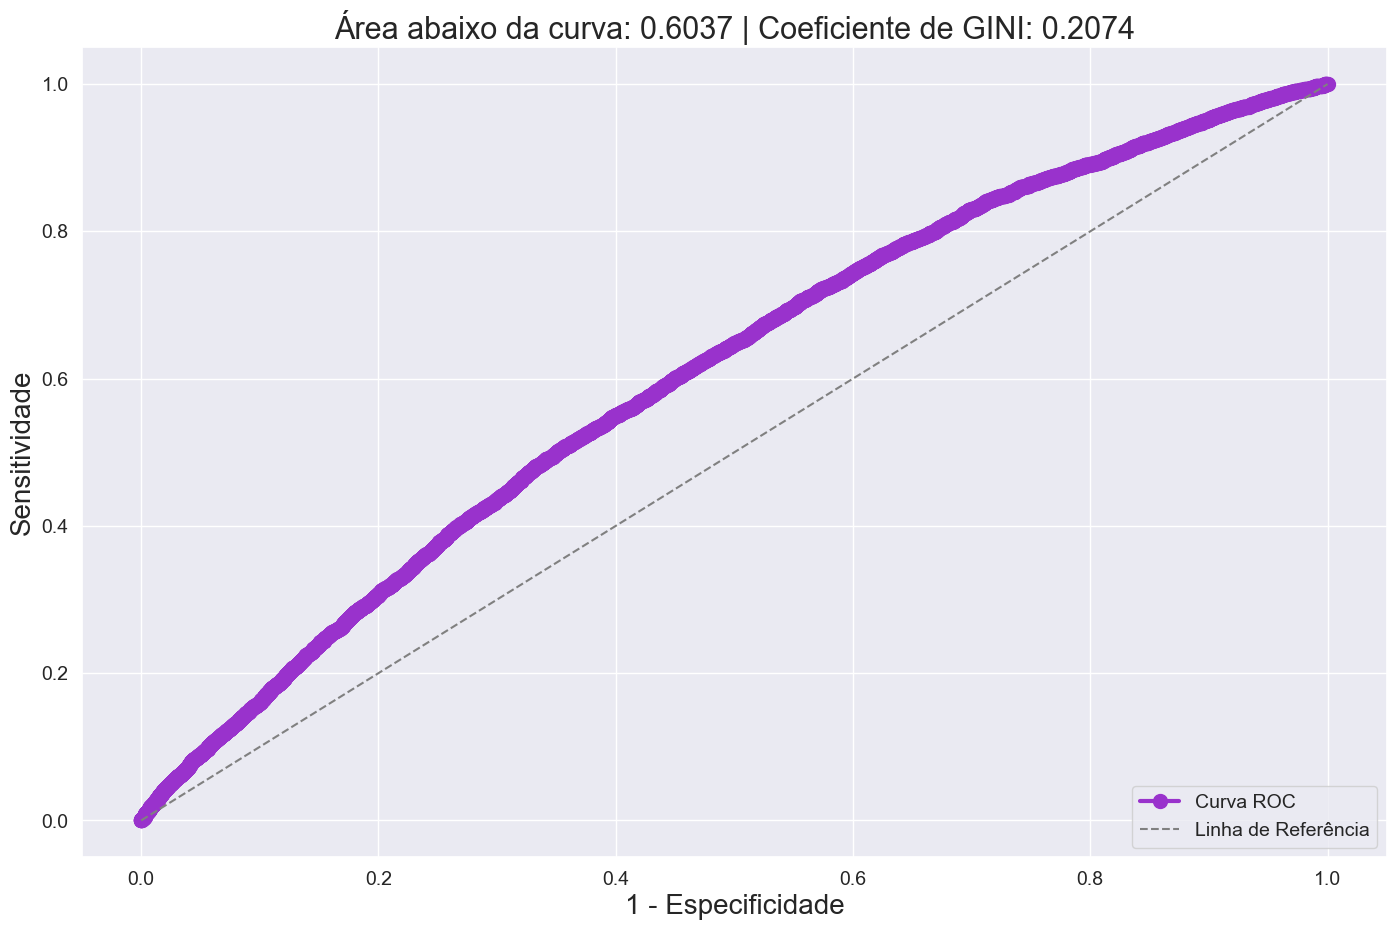

In [49]:
plot_roc_curve(data_with_pca['target_default'], data_with_pca['phat'])

### Interpretação da Área Sob a Curva ROC (AUC-ROC)

A área sob a curva ROC (AUC-ROC) varia entre 0 e 1:

- 1.0 → Modelo perfeito
- 0.5 → Modelo aleatório (equivalente a um chute)
- < 0.5 → Modelo pior que o aleatório (indicando possível erro na classificação)

No resultado acima de AUC = 0.6037, significa que o modelo tem um desempenho ligeiramente melhor do que um modelo aleatório, mas ainda é fraco. Em termos práticos, ele acerta a classificação correta em 60,3% dos casos.

### Interpretação do Coeficiente de Gini

O Coeficiente de Gini é calculado como:

$$G=2×AUC−1$$

Aplicando no case:

$$G=2×0.6037−1=0.2074$$

O coeficiente de Gini varia entre 0 e 1, onde:

- 1.0 → Modelo perfeito
- 0.0 → Modelo aleatório
- Valores negativos → Modelo pior que o aleatório

Com o resultado do modelo Gini de 0.20, confirma que o modelo tem baixa capacidade preditiva, mas ainda faz um trabalho um pouco melhor do que um chute aleatório.

### Conclusão

O modelo tem baixa capacidade de discriminação entre classes. Como é um modelo de crédito, ele precisa distinguir melhor bons e maus pagadores.

O que pode ser feito?

- Revisar as variáveis preditoras para melhorar a qualidade dos dados.
- Testar modelos de machine learning (árvores de decisão, redes neurais, etc.).
- Realizar feature engineering para extrair melhores padrões dos dados.
- Balancear os dados se houver desbalanceamento entre classes.
- Colocar mais variáveis independentes na base.


# Pipeline para Machine Learning com o DataFrame do PCA

Um pipeline de machine learning é uma sequência automatizada e organizada de etapas que transforma dados brutos em um modelo de machine learning pronto para uso. Ele integra várias tarefas, como pré-processamento de dados, seleção de características, treinamento do modelo, avaliação e implantação, em um fluxo de trabalho coeso. O objetivo é simplificar, padronizar e acelerar o processo de desenvolvimento de modelos, garantindo consistência e reprodutibilidade.

Implementaremos primeiramente aqui no Pipeline o StandardScaler().

O StandardScaler() é uma ferramenta do scikit-learn, usada para padronizar as características (features) de um conjunto de dados. A padronização é um processo comum em pré-processamento de dados, especialmente em algoritmos que são sensíveis à escala das features, como SVM, regressão linear, e redes neurais.

O que o StandardScaler() faz?

Ele transforma os dados de forma que a distribuição resultante tenha:

- Média zero: A média dos valores de cada feature é ajustada para 0.

- Variância unitária: A variância dos valores de cada feature é ajustada para 1.

Isso é feito subtraindo a média dos valores e dividindo pelo desvio padrão. Matematicamente, para cada valor 
$x$ de uma feature:

$$ z = \frac{x - \mu}{\sigma} $$

Onde:

$μ$ é a média da feature.

$σ$ é o desvio padrão da feature.

Quando usar o StandardScaler()?

- Quando os algoritmos de machine learning que você está usando são sensíveis à escala dos dados.

- Quando as features têm unidades diferentes (por exemplo, metros e quilogramas).

- Quando você deseja que todas as features contribuam igualmente para o modelo, evitando que features com valores maiores dominem o processo de aprendizado.


**Vamos utilizar o DataFrame criado através do método PCA.**

**O PCA foi usado para reduzir a quantidade de variáveis e criar um conjunto de variáveis (componentes principais) que capturam a maior parte da variação dos dados, facilitando a análise e a modelagem do risco de crédito.**

- Visualização dos dados criados com PCA.

In [50]:
data_with_pca.head()

,PC1,PC2,PC3,PC4,PC9,PC10,PC11,target_default,phat
0,-0.42,1.10,0.55,-1.14,0.96,-0.83,-0.84,0,0.10
1,0.32,0.85,0.23,-0.75,0.52,-0.35,-0.39,0,0.12
2,-1.87,-0.82,0.31,0.28,-0.31,1.15,0.75,0,0.18
3,-1.42,-1.25,-0.07,-0.34,0.19,0.24,0.22,0,0.12
4,-1.85,-0.55,-2.07,-0.60,0.03,0.08,0.47,0,0.11


- Exclusão da variável "phat" com as probabilidades previstas pelo modelo logístico binário.

In [51]:
final_data_with_pca = data_with_pca.copy()
exclude_phat = ["phat"]
final_data_with_pca.drop(labels = exclude_phat, axis=1, inplace=True)
final_data_with_pca.head()

,PC1,PC2,PC3,PC4,PC9,PC10,PC11,target_default
0,-0.42,1.10,0.55,-1.14,0.96,-0.83,-0.84,0
1,0.32,0.85,0.23,-0.75,0.52,-0.35,-0.39,0
2,-1.87,-0.82,0.31,0.28,-0.31,1.15,0.75,0
3,-1.42,-1.25,-0.07,-0.34,0.19,0.24,0.22,0
4,-1.85,-0.55,-2.07,-0.60,0.03,0.08,0.47,0


- Divisão dos dados em X e Y.

In [52]:
X_with_pca = final_data_with_pca.drop(columns=['target_default'], axis = 1)	
y_with_pca = final_data_with_pca['target_default'].copy() 

- Novo Train Test Split para os dados com PCA.

In [53]:
X_train_with_pca, X_test_with_pca, y_train_with_pca, y_test_with_pca = train_test_split(X_with_pca, y_with_pca, test_size=0.2,random_state=42)

- Pipeline.

In [54]:
numerical_features_with_pca = X_train_with_pca.select_dtypes('number').columns.to_list()

numerical_pipeline = Pipeline(
    steps=[
        ('std_scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', numerical_pipeline, numerical_features_with_pca)
    ], remainder="passthrough"
)

- X_train_prepared_with_pca preparado para rodar os modelos.

In [55]:
X_train_prepared_with_pca = preprocessor.fit_transform(X_train_with_pca, y_train_with_pca)
X_train_prepared_with_pca.shape

(28800, 7)

# Criação dos Modelos de ML

Vamos avaliar diferentes modelos de classificação do conjunto de dados previamente preparados. Utilizando a métrica **ROC AUC** para comparar o desempenho dos modelos e empregar validação cruzada estratificada para garantir resultados mais confiáveis.

Para esta análise de risco de crédito com uma base de 36.000 registros e 17 features, é preciso escolher modelos de machine learning que sejam mais robustos, capazes de lidar com os dados desbalanceados. Abaixo segue os modelos escolhidos:

## Modelos Utilizados
Os seguintes modelos de classificação são avaliados:
- **Logistic Regression**
- **Random Forest**
- **XGBoost**
- **LGBM**
- **CatBoost**

## Logistic Regression (Regressão Logística)

- A Regressão Logística já foi explicada logo acima, mas para relembrar dizemos que é um algoritmo de classificação usado para estimar valores discretos com base em um conjunto de variáveis indepentes, valores binários como "Sim" ou "Não", "Verdadeiro" ou "Falso" ou simplesmente "0" e "1".

- Por ser um modelo simples e de fácil interpretação, a Regressão Logística permite entender a importância de cada variável na decisão de risco de crédito.

- Pelo tamanho do dataset utilizado, funcionará bem.

- Como a Regressão Logística utiliza a probabilidade, fornece as probabilidades de inadimplência, sendo útil para tomar as decisões de risco.

## Bagging e Boosting 

![Matriz_de_Confusao](../images/bagging_boosting.png)

**Bagging**

Antes de mostrar o que são os modelos seguintes, precisamos entender o que é Bagging e Boosting em Machine Learning.

Bagging e Boosting são técnicas de Ensemble Learning, uma técnica onde múltiplos modelos são combinados para obter um desempenho melhor do que qualquer modelo individual. A idéia central é que, ao unir diferentes modelos, os erros de um podem ser compensados pelos acertos de outro, resultando em previsões mais robustas e precisas. 

O Bagging tem como objetivo reduzir a variância dos modelos e evitar o overfitting. Ele gera várias amostras do conjunto de treinamento usando bootstrap com amostragem com reposição.

Bootstrap é um método estatístico de reamostragem usado para estimar a distribuição de uma estatística (como a média, mediana e desvio padão) a partir de uma amostra de dados.

E com a Amostragem com Reposição o Bootstrap através de um conjunto de dados original com $n$ observações, gera novas amostras, retirando $n$ observações com reposição.

Com essas novas amostras, o Bagging treina um modelo em cada amostra, e depois faz a média para regressão ou sua votação majoritária para classificação para combinar os resultados. 

O Random Forest é um exemplo clássico de Bagging. Ele treina várias árvores de decisão em subconjuntos dos dados e combina os resultados para melhorar a precisão e a generalização.

Em resumo, no Bagging se constrói vários modelos (geralmente do mesmo tipo de algoritmo) a partir de diferentes subamostras do conjunto de dados de treinamento.

**Boosting**

O objetivo do Boosting é melhorar o desempenho focando nos erros cometidos pelos modelos. Ele treina um modelo inicial nos dados, depois os exemplos que o modelo previu errado recebem mais peso. Depois treina um novo modelo que tenta corrigir esses erros e repete esse processo várias vezes, combinando os modelos sequencialmente.

Em resumo, no Boosting se constrói vários modelos (geralmente do mesmo tipo de algoritmo) e cada um deles aprende a corrigir os
erros de predição de um modelo anterior na sequência de modelos.

## Comparação entre Boosting e Bagging

| Característica        | Boosting                              | Bagging                                    |
|-----------------------|--------------------------------------|---------------------------------------------|
| Objetivo              | Reduzir viés                         | Reduzir variância                           |
| Como funciona?        | Modelos treinados sequencialmente    | Modelos treinados independentemente         |
| Combinação de modelos | Modelos ajustam erros anteriores     | Média (regressão) / Votação (classificação) |
| Risco de overfitting  | Maior (se não for bem ajustado)      | Menor                                       |
| Exemplo de Modelo(s)  | AdaBoost, XGBoost, LGBM, CatBoost    | Random Forest                               |


## Random Forest

- O Random Forest (ou Floresta Aleatória) é um algoritmo amplamente utilizado para tarefas de classificação e regressão. Ele pertence ao conjunto de métodos conhecidos como ensemble learning, que combinam múltiplos modelos para melhorar a precisão e a robustez das previsões.

- Utiliza múltiplas árvores de decisão para reduzir o overfitting e melhorar a generalização.

- Permite identificar quais variáveis são mais importantes para a previsão.

- Lida bem com dados desbalanceados.

O Random Forest é uma evolução do método tradicional de Bagging com Árvores de Decisão. Esse algoritmo gera modelos base a partir de diversas subamostras aleatórias do conjunto de treinamento. 

Durante o processo de treinamento de cada modelo, é selecionado um subconjunto aleatório dos atributos para determinar a divisão da árvore em cada nó, buscando o melhor atributo dentro da subamostra de atributos. 

Para cada um desses atributos, o algoritmo encontra o ponto de corte ideal. Esse processo aumenta a diversidade das árvores, frequentemente levando à formação de um ensemble mais eficaz.

## XGBoost, LGBM e CatBoost que fazem parte dos (GBMs) Gradient Boosting Machines

- Gradient Boosting Machines (GBMs), são um conjunto de algoritmos de aprendizado de máquina que utilizam o boosting para construir modelos preditivos poderosos. Eles funcionam combinando vários modelos fracos (geralmente árvores de decisão) para criar um modelo forte e preciso.

- O Boosting melhora a precisão do modelo.

- Reduz viés sem aumentar muito a variância.

- Devido a uma alta precisão nas previsões, os 3 modelos que fazem parte do (GBMs) é conhecido por sua alta performance em problemas de classificação, incluindo risco de crédito.

- Também lida bem com dados desbalanceados.

**XGBoost(eXtreme Gradient Boosting)**


**LightGBM (LGBM)**


**CatBoost**




## Metodologia

1. Cada modelo é instanciado e treinado com os dados de treino (`X_train_prepared_with_pca`, `y_train_with_pca`).
2. O tempo de treinamento de cada modelo é registrado.
3. As previsões são feitas tanto no conjunto de treino (`X_train_prepared_with_pca`) quanto no conjunto de teste (`X_test_with_pca`).
4. O desempenho é avaliado utilizando a métrica **ROC AUC**:
   - **Score no conjunto de treino**
   - **Média da validação cruzada** (`cross_val_score` com 5 folds estratificados)
   - **Desvio padrão da validação cruzada**
5. Os resultados são armazenados em dicionários para análise posterior:
   - `models_train_scores`: armazena o ROC AUC do treino.
   - `models_val_scores`: armazena a média do ROC AUC na validação cruzada.
6. Os resultados de cada modelo são impressos no console, incluindo o tempo de treinamento.
7. Como temos dados desbalanceados (exemplo: 90% de uma classe e 10% de outra), será utilizada a técnica de Class Weight para dar mais peso à classe minoritária e reduzir o viés do modelo:
   - **scale_pos_weight = sum(y == 0) / sum(y == 1)**
   - Calculo para a razão entre as classes
   - É usado para calcular o peso da classe positiva em problemas de classificação desbalanceada, compensando o desbalanceamento.

Logistic Regression results: 
--------------------------------------------------
Training score: 0.5745841574866568
Average validation score: 0.6036555146462097
Standard deviation: 0.012024441198031944
Training time: 0.01316 seconds

Random Forest results: 
--------------------------------------------------
Training score: 0.9998831502687544
Average validation score: 0.5592670344209225
Standard deviation: 0.010161049341985463
Training time: 7.53022 seconds

XGBoost results: 
--------------------------------------------------
Training score: 0.8547636944468305
Average validation score: 0.5568476899904586
Standard deviation: 0.00913865172251509
Training time: 0.29739 seconds

[LightGBM] [Info] Number of positive: 4279, number of negative: 24521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the trai

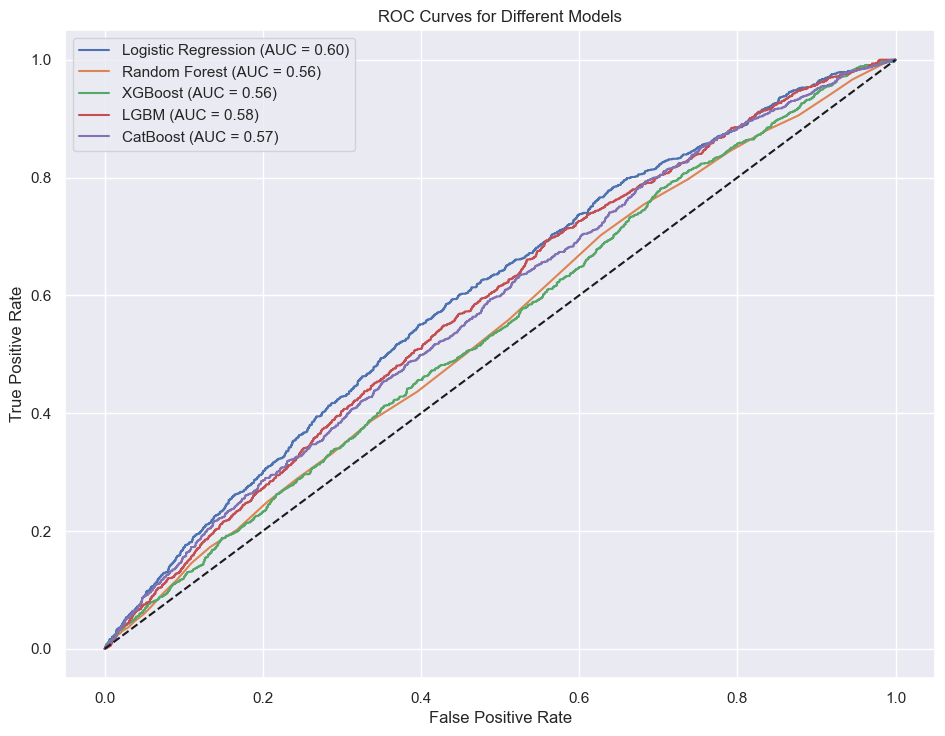

In [56]:
# Calcule a razão entre as classes
# é usado para calcular o peso da classe positiva em problemas de classificação desbalanceada, compensando o desbalanceamento.
scale_pos_weight = sum(y == 0) / sum(y == 1)

models = {
    'Logistic Regression': LogisticRegression(class_weight="balanced", random_state=42),
    'Random Forest': RandomForestClassifier(class_weight="balanced", random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss"),
    'LGBM': lgb.LGBMClassifier(is_unbalance=True),
    'CatBoost': CatBoostClassifier(class_weights=[1, scale_pos_weight])
}



model_list = []
models_val_scores = {}
models_train_scores = {}

n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))

for name, model in models.items():
    start_time = time.time()
    
    model.fit(X_train_prepared_with_pca, y_train_with_pca) 
    
    end_time = time.time()
    training_time = end_time - start_time
    
    y_train_pred = model.predict(X_train_prepared_with_pca)
    y_test_pred = model.predict(X_test_with_pca)
    
    train_score = roc_auc_score(y_train_with_pca, y_train_pred)
    val_scores = cross_val_score(model, X_train_prepared_with_pca, y_train_with_pca, scoring='roc_auc', cv=stratified_kfold)
    avg_val_score = val_scores.mean()
    val_score_std = val_scores.std()
    
    models_val_scores[name] = avg_val_score
    models_train_scores[name] = train_score
    model_list.append(name)
    
    # Cálculo da curva ROC
    y_test_prob = model.predict_proba(X_test_with_pca)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_with_pca)
    fpr, tpr, _ = roc_curve(y_test_with_pca, y_test_prob)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {avg_val_score:.2f})')
    
    print(f'{name} results: ')
    print('-' * 50)
    print(f'Training score: {train_score}')
    print(f'Average validation score: {avg_val_score}')
    print(f'Standard deviation: {val_score_std}')
    print(f'Training time: {round(training_time, 5)} seconds')
    print()

plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()


# Relatório de Desempenho dos Modelos

Este relatório apresenta os resultados de treinamento e validação de cinco modelos de machine learning: **Regressão Logística**, **Random Forest**, **XGBoost**, **LGBM** e **CatBoost**. As métricas avaliadas incluem a pontuação de treinamento, a pontuação média de validação, o desvio padrão da validação e o tempo de treinamento.

---

## Resultados Detalhados

### 1. Regressão Logística
- **Pontuação de Treinamento:** 0.5746
- **Pontuação Média de Validação:** 0.6037
- **Desvio Padrão da Validação:** 0.0120
- **Tempo de Treinamento:** 0.0183 segundos

### 2. Random Forest
- **Pontuação de Treinamento:** 0.9999
- **Pontuação Média de Validação:** 0.5593
- **Desvio Padrão da Validação:** 0.0102
- **Tempo de Treinamento:** 7.6765 segundos

### 3. XGBoost
- **Pontuação de Treinamento:** 0.8548
- **Pontuação Média de Validação:** 0.5568
- **Desvio Padrão da Validação:** 0.0091
- **Tempo de Treinamento:** 0.1748 segundos

### 4. LGBM
- **Pontuação de Treinamento:** 0.7342
- **Pontuação Média de Validação:** 0.5801
- **Desvio Padrão da Validação:** 0.0099
- **Tempo de Treinamento:** 0.1190 segundos

### 5. CatBoost
- **Pontuação de Treinamento:** 0.7705
- **Pontuação Média de Validação:** 0.5731
- **Desvio Padrão da Validação:** 0.0105
- **Tempo de Treinamento:** 9.3469 segundos

---

## Análise Comparativa

### Pontuação de Validação
- O modelo com a **maior pontuação média de validação** foi a **Regressão Logística (0.6037)**, seguido pelo **LGBM (0.5801)** e **CatBoost (0.5731)**.
- **Random Forest** e **XGBoost** tiveram as menores pontuações de validação, com 0.5593 e 0.5568, respectivamente.

### Overfitting
- O **Random Forest** apresentou um claro sinal de overfitting, com uma pontuação de treinamento próxima de 1.0 (0.9999), mas uma pontuação de validação significativamente menor (0.5593).
- A **Regressão Logística** mostrou o menor overfitting, com pontuações de treinamento e validação mais próximas.

### Tempo de Treinamento
- O modelo mais rápido foi a **Regressão Logística (0.0183 segundos)**, enquanto o mais lento foi o **CatBoost (9.3469 segundos)**.
- **XGBoost** e **LGBM** tiveram tempos de treinamento intermediários, com 0.1748 e 0.1190 segundos, respectivamente.

### Consistência (Desvio Padrão)
- O **XGBoost** apresentou o menor desvio padrão (0.0091), indicando maior consistência nas pontuações de validação.
- A **Regressão Logística** teve o maior desvio padrão (0.0120), sugerindo maior variabilidade nos resultados.

---

## Conclusão
- A **Regressão Logística** foi o modelo com melhor equilíbrio entre desempenho e generalização, apresentando a maior pontuação de validação e menor overfitting.
- **Random Forest** e **XGBoost** tiveram desempenho inferior em validação, com o primeiro apresentando overfitting significativo.
- **LGBM** e **CatBoost** mostraram desempenho intermediário, com tempos de treinamento maiores em comparação à Regressão Logística.
- Para cenários onde o tempo de treinamento é crítico, a **Regressão Logística** e o **LGBM** são as melhores opções.

---

**Recomendação:** Utilize a **Regressão Logística** como modelo principal devido ao seu bom desempenho em validação e baixo tempo de treinamento. Para melhorias futuras, considere ajustes de hiperparâmetros nos modelos **LGBM** e **CatBoost**.

# Tunagem de Hiperparâmetros

A tunagem de hiperparâmetros é uma etapa crucial no treinamento de modelos de machine learning, pois permite encontrar a combinação ideal de hiperparâmetros para melhorar o desempenho do modelo. Aqui estão algumas das principais técnicas e opções de tunagem de hiperparâmetros:

O **Grid Search CV**, o **Random Search** e a **Otimização Bayesiana** são as técnicas mais usadas para otimizar hiperparâmetros em modelos de aprendizado de máquina, mas cada uma tem suas características.

O **Grid Search CV** testa todas as combinações possíveis de hiperparâmetros dentro de uma grade predefinida, garantindo a melhor solução dentro do espaço explorado. Porém, é computacionalmente custoso, especialmente com muitos parâmetros.

O **Random Search** escolhe aleatoriamente combinações de hiperparâmetros e pode ser mais eficiente que o Grid Search, especialmente quando há muitos parâmetros. No entanto, não garante encontrar a melhor solução.

A **Otimização Bayesiana** utiliza um modelo probabilístico para escolher as melhores combinações de forma inteligente, aprendendo com as tentativas anteriores. É mais eficiente que as duas anteriores, exigindo menos tentativas para encontrar a solução ideal, mas pode ser mais complexa de implementar.

## Metodologia 

Para um projeto de risco de crédito com uma base de dados relativamente pequena, e considerando que não temos muito tempo devido ao custo computacional, é importante focar em uma abordagem eficiente para a tunagem de hiperparâmetros. Precisamos de um método que priorize equilibrio e desempenho em pouco tempo de execução, vamos iniciar a tunagem utilizando o **Random Search** para o modelo **Random Forest**, devido ao seu **Overfitting** no resultado. 

O **Training Score** de **(0.99)** no modelo de **Random Forest** indica um ajuste quase perfeito aos dados de treinamento, o que pode ser causado por:

**Limitações do Modelo**: O modelo está se ajustando excessivamente aos dados de treinamento possivelmente devido à alta complexidade do Random Forest ou à falta de limitações nos hiperparâmetros (como max_depth ou n_estimators).

**Class Weight**="balanced": O ajuste de pesos para classes desbalanceadas pode tornar o modelo muito sensível às classes minoritárias, aumentando o ajuste aos dados de treinamento.

**Número de Features e Amostras**: Com 7 features e 28.800 registros criadas através do método PCA, o modelo tem dados suficientes para encontrar padrões complexos, facilitando o alto **Training Score**.

**StratifiedKFold**: O uso de **StratifiedKFold** garante a proporção das classes, mas o **Training Score** é calculado apenas nos dados de treinamento, não refletindo a generalização do modelo.

**Complexidade do Modelo**: O Random Forest é naturalmente propenso a capturar padrões complexos, o que pode levar a um ajuste excessivo.

**Possível Vazamento de Dados**: Se o pré-processamento não for feito corretamente, informações dos dados de validação/teste podem vazar para o treinamento.


In [57]:
# Definição dos hiperparâmetros para o Random Search
param_dist = {
    'n_estimators': randint(100, 1000),  # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidade máxima das árvores
    'min_samples_split': randint(2, 20),  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 20),   # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de features para considerar ao buscar a melhor divisão
    'bootstrap': [True, False],  # Se as amostras são bootstrapadas ao construir árvores
    'class_weight': ['balanced']  # Já definido como "balanced"
}

# Criação do modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Configuração do StratifiedKFold com 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinações de hiperparâmetros a serem testadas
    scoring='accuracy',  # Métrica de avaliação (pode ser alterada para 'roc_auc', 'f1', etc.)
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usar todos os núcleos disponíveis
)

# Execução da busca
random_search.fit(X_train_prepared_with_pca, y_train_with_pca)

print("Melhores hiperparâmetros encontrados: ", random_search.best_params_)
print("Melhor score de validação cruzada: ", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores hiperparâmetros encontrados:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 317}
Melhor score de validação cruzada:  0.8479166666666667


In [58]:
# Extrair os resultados do RandomizedSearchCV
results = random_search.cv_results_

# DataFrame dos resultados
results_df = pd.DataFrame({
    'params': results['params'],  # Combinações de hiperparâmetros testadas
    'mean_test_score': results['mean_test_score'],  # Score médio de validação cruzada
    'std_test_score': results['std_test_score'],  # Desvio padrão do score
    'rank_test_score': results['rank_test_score']  # Rank do score (1 é o melhor)
})

# Ordenação do DataFrame pelo rank (melhores resultados primeiro)
results_df = results_df.sort_values(by='rank_test_score').reset_index(drop=True)

# Exibição do DataFrame
results_df.head() # Mostrar as primeiras linhas do DataFrame

,params,mean_test_score,std_test_score,rank_test_score
0,"{'bootstrap': True, 'class_weight': 'balanced'...",0.85,0.00,1
1,"{'bootstrap': True, 'class_weight': 'balanced'...",0.84,0.00,2
2,"{'bootstrap': True, 'class_weight': 'balanced'...",0.84,0.00,3
3,"{'bootstrap': False, 'class_weight': 'balanced...",0.83,0.00,4
4,"{'bootstrap': True, 'class_weight': 'balanced'...",0.83,0.00,5


Explicação das Colunas:

- **params**: As combinações de hiperparâmetros testadas.

- **mean_test_score**: A média do score de validação cruzada para cada combinação de hiperparâmetros.

- **std_test_score**: O desvio padrão do score de validação cruzada, que indica a variabilidade do desempenho entre os folds.

- **rank_test_score**: O rank de cada combinação de hiperparâmetros, onde 1 é a melhor combinação.

Explicação dos resultados:

- O modelo com o conjunto de hiperparâmetros mais equilibrado (com class_weight como balanced e bootstrap como True) obteve a melhor pontuação média de teste de **0,85**.

- Todos os modelos têm um desvio padrão de **0,00**, o que sugere que não houve variação significativa nos resultados, e que o modelo é robusto.

- A variação no desempenho entre os conjuntos de hiperparâmetros é pequena, mas o melhor conjunto de hiperparâmetros (classificado como 1) parece ser o mais eficaz.

## Teste e avaliação do modelo

In [59]:
final_random_forest_classifier = random_search.best_estimator_ 

In [60]:
X_test_prepared = preprocessor.transform(X_test_with_pca)
X_test_prepared.shape

(7200, 7)

In [61]:
final_predictions = final_random_forest_classifier.predict(X_test_prepared)

## Avaliando o modelo final ajustado de Random Forest.

**Matriz de Confusão**

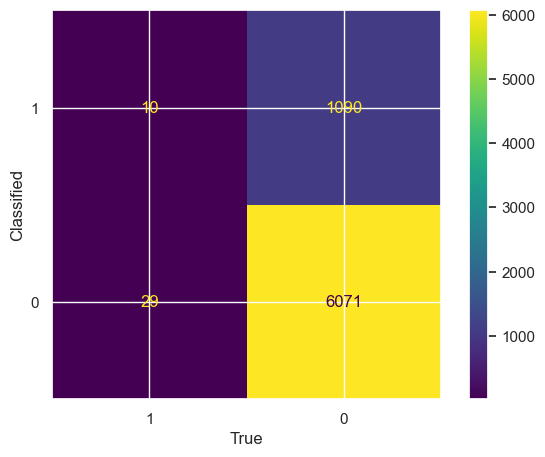

,Sensitividade,Especificidade,Acurácia
0,0.26,0.85,0.84


In [62]:
# Matriz de confusão para cutoff = 0.2
matriz_confusao(y_test_with_pca,
                final_predictions, 
                cutoff=0.2)

**Curva ROC**

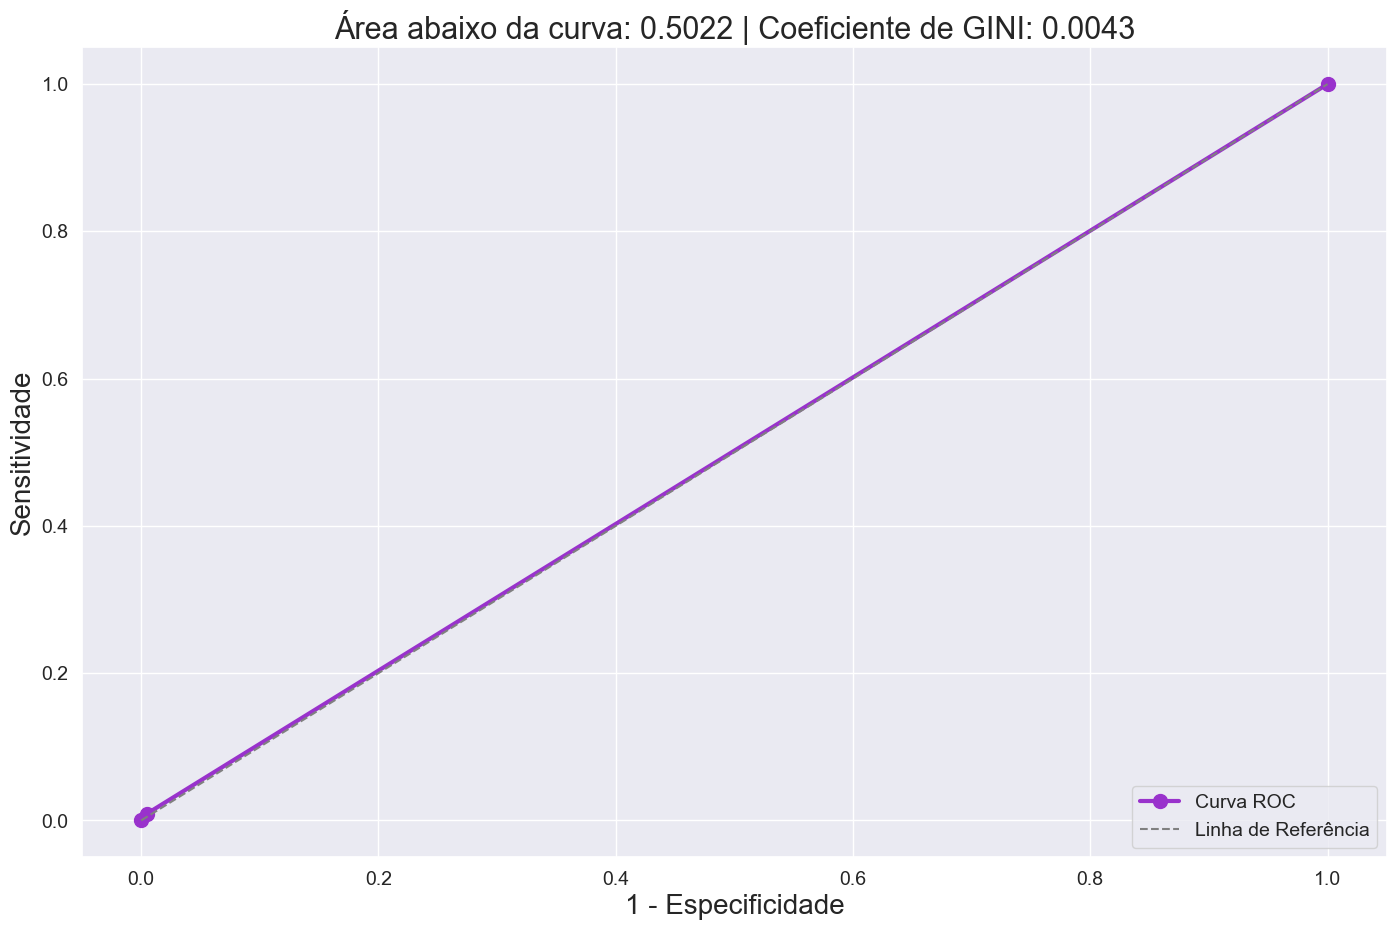

In [63]:
plot_roc_curve(y_test_with_pca, final_predictions)

## Interpretação:

**Matriz de Confusão**

A classe negativa é dominante **(VN = 6071)**, enquanto a classe positiva é rara **(VP = 10, FN = 29)**.

O modelo está tendendo a prever a classe negativa, o que resulta em alta acurácia e especificidade, mas baixa precisão e recall para a classe positiva.

O número de falsos positivos **(FP = 1090)** é muito alto em relação aos verdadeiros positivos **(VP = 10)**. Isso indica que o modelo está classificando muitos casos negativos como positivos, o que pode ser crítico no risco de crédito dependendo da escolha do cutoff.

O número de falsos negativos **(FN = 29)** também é significativo em relação aos verdadeiros positivos **(VP = 10)**. Isso significa que o modelo está perdendo muitos casos positivos, o que pode ser problemático em cenários onde a classe positiva é crítica.

- **Acurácia** é alta **(84%)**. Isso pode ser enganoso devido ao desequilíbrio das classes **(muitos verdadeiros negativos)**.

- **Sensitividade** moderada **(26%)**. Mostra que o modelo não está capturando bem os casos positivos.

- **Especificidade** alta **(85%)**. Indica que o modelo é bom em identificar corretamente os casos negativos.

O resultado tem um desempenho ruim para a classe positiva, com baixa sensitividade. A alta acurácia é enganosa devido ao desequilíbrio das classes. Para melhorar o modelo, é essencial equilibrar as classes, ajustar o threshold de classificação e considerar métricas mais adequadas para cenários com desequilíbrio.

**Curva ROC**

Com o valor da **AUC = 0.5022** e o **GINI = 0.0043** indica que o modelo tem uma capacidade discriminatória muito próxima de um modelo aleatório, isto é, que o modelo não consegue distinguir adequadamente entre as classes que está tentando prever **(por exemplo, bons pagadores vs. maus pagadores, em um modelo de risco de crédito)**. O coeficiente de Gini **(GINI)** é uma métrica derivada da AUC, onde **GINI = 2 * AUC - 1**. Portanto, um GINI próximo de zero também reforça que o modelo não está conseguindo separar adequadamente as classes **(bons pagadores vs. maus pagadores, por exemplo)**.

## Conclusão:

Portanto o modelo não é adequado para uso em decisões de risco de crédito, pois não consegue discriminar adequadamente entre bons e maus pagadores. É necessário revisar o processo de modelagem, desde a seleção de variáveis até a escolha do algoritmo, para melhorar o desempenho do modelo.

O modelo que mais se destacou foi a **Regressão Logística**.

